In [119]:
suppressMessages(library(caret))
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(pROC))

set.seed(42)

In [120]:
meta_data = read.delim("../files_for_manuscript/meta_data.txt", header=T)
counts = read.delim("../files_for_manuscript/count_matrix.txt", row.names=c(1))
top150= read.delim("../files_for_manuscript/top150genes.csv")

In [121]:
meta_data$Microbiologic.reference.standard = gsub(meta_data$Microbiologic.reference.standard, pattern="TB ", replacement="")

meta_data$group <- factor(meta_data$Microbiologic.reference.standard, levels = c("Positive","Negative"))
meta_data = meta_data[!is.na(meta_data$group),]

In [122]:
gene_blacklist <-  read.delim("../files_for_manuscript/genes_to_exlude.tsv",col.names = c("type,","ENSMBL","gene_symbol"))   ## read in gene list to exclude
cols = intersect(colnames(counts), meta_data$Cornell_ID)
count_matrix = counts
gene.ids <- gsub("\\..*","",rownames(count_matrix))                                                ## clean up any weird gene names

exclude.idx <- gene.ids %in% gene_blacklist[,2]

count_matrix = count_matrix[!exclude.idx,]                                                         ## exclude genes

meta_data = meta_data[meta_data$Cornell_ID %in% cols,]
count_matrix <- count_matrix[,meta_data$Cornell_ID]   


In [123]:
gene.list = read.delim("../files_for_manuscript/gencode.biotype.name.key.tsv")
sig_genes = gene.list[gene.list$gene_name %in% top150$x,1]

In [124]:
meta_data_train <- meta_data %>% slice_sample(prop=0.7)


## create test data based on left overs
meta_data_test <- meta_data %>% filter(!(Cornell_ID %in% meta_data_train$Cornell_ID))

    ## Subset count matrixs
count_matrix_train <- count_matrix[,meta_data_train$Cornell_ID]
count_matrix_test <- count_matrix[,meta_data_test$Cornell_ID]
count_matrix_train = count_matrix_train[rownames(count_matrix_train) %in% sig_genes,]
count_matrix_test = count_matrix_test[rownames(count_matrix_test) %in% sig_genes,]
    ## rename rows
rownames(count_matrix_train) <- gsub("\\_.*","",rownames(count_matrix_train))
rownames(count_matrix_test) <- gsub("\\_.*","",rownames(count_matrix_test))



## GLM_TRAIN

In [125]:
counts_train$y = factor(meta_data_train$group)
model_weights = ifelse(counts_train$y == names(table(counts_train$y)[1]),
                        (1/table(counts_train$y)[1])*0.5,
                      (1/table(counts_train$y)[2])*0.5)


metric = "Accuracy"

control = trainControl(method="cv", number=5)

tunegrid = expand.grid(alpha=0, lambda = seq(0.00001, 1, length=10000))

glmnet_fit = train(y~., data = counts_train, metric = metric, method="glm",
                  preProcess = c("center","scale"), 
                  trControl = control, 
                   #weights = model_weights,
                 family="binomial")

#glmnet_fit

tpred = predict(glmnet_fit, counts_train, type = "prob")
meta_data_train$classifier_score = as.numeric(tpred[,1])
youden_threshold = coords(roc(meta_data_train$group, meta_data_train$classifier_score),
                         x="best", input="threshold", best.method="youden")$threshold

tpred = predict(glmnet_fit, newdata = counts_test, type="prob")
meta_data_test$classifier_score = as.numeric(tpred[,1])

meta_data_test$class_prediction <-
      ifelse(meta_data_test$classifier_score > youden_threshold,
             "Positive",
             "Negative"
      )
meta_data_train$class_prediction <-
      ifelse(meta_data_train$classifier_score > youden_threshold,
             "Positive",
             "Negative"
      )



Warning message:
“glm.fit: algorithm did not converge”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message:
“glm.fit: algorithm did not converge”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message:
“glm.fit: algorithm did not converge”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message:
“glm.fit: algorithm did not converge”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warning message:
“glm.fit: algorithm did not converge”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”
Warni

In [126]:
print("train")
auc(meta_data_train$group ~ meta_data_train$classifier_score, plot = FALSE, print.auc = TRUE)
glm_train_auc =ci.auc(meta_data_train$group ~ meta_data_train$classifier_score, plot = FALSE, print.auc = TRUE)
glm_train =ci.coords(meta_data_train$group ~ meta_data_train$classifier_score, conf.level = 0.95, best.method="youden",
          x="best",
         ret = c("sensitivity","specificity", "accuracy","ppv","npv")) %>% data.frame()
youden=coords(roc(meta_data_train$group ~ meta_data_train$classifier_score),  best.method="youden",
          x="best")$threshold
print("test")
auc(meta_data_test$group ~ meta_data_test$classifier_score, plot = FALSE, print.auc = TRUE)
glm_test_auc = ci.auc(meta_data_test$group ~ meta_data_test$classifier_score, plot = FALSE, print.auc = TRUE)
glm_test = ci.coords(meta_data_test$group ~ meta_data_test$classifier_score,  input="threshold",
         x=youden,
         ret = c("sensitivity","specificity", "accuracy","ppv","npv")) %>% data.frame()

[1] "train"


Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



Area under the curve: 1

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Warning message in ci.auc.roc(roc.default(response, predictor, ci = FALSE, ...), :
“ci.auc() of a ROC curve with AUC == 1 is always 1-1 and can be misleading.”
Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Warning message in ci.coords.roc(roc(response, predictor, ci = FALSE, ...), ...):
“ci.coords() of a ROC curve with AUC == 1 is always a null interval and can be misleading.”
Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



[1] "test"


Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



Area under the curve: 0.5743

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



## GLMNET Ridge

glmnet 

127 samples
150 predictors
  2 classes: 'Positive', 'Negative' 

Pre-processing: centered (150), scaled (150) 
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 101, 101, 101, 103, 102 
Resampling results across tuning parameters:

  alpha  lambda      Accuracy   Kappa    
  0.10   0.01830496  0.8052051  0.6102564
  0.10   0.05788536  0.8366154  0.6730769
  0.10   0.18304957  0.8282821  0.6564103
  0.55   0.01830496  0.8199487  0.6397436
  0.55   0.05788536  0.8205897  0.6410256
  0.55   0.18304957  0.8048718  0.6093577
  1.00   0.01830496  0.8125641  0.6252560
  1.00   0.05788536  0.8128974  0.6256410
  1.00   0.18304957  0.7577692  0.5147643

Accuracy was used to select the optimal model using the largest value.
The final values used for the model were alpha = 0.1 and lambda = 0.05788536.

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases




Call:
roc.formula(formula = meta_data_test$group ~ meta_data_test$classifier_score,     plot = FALSE, print.auc = TRUE)

Data: meta_data_test$classifier_score in 37 controls (meta_data_test$group Positive) > 18 cases (meta_data_test$group Negative).
Area under the curve: 0.9084

Warning message in confusionMatrix.default(factor(meta_data_test$class_prediction), :
“Levels are not in the same order for reference and data. Refactoring data to match.”


Confusion Matrix and Statistics

          Reference
Prediction Positive Negative
  Positive       30        3
  Negative        7       15
                                         
               Accuracy : 0.8182         
                 95% CI : (0.691, 0.9092)
    No Information Rate : 0.6727         
    P-Value [Acc > NIR] : 0.01259        
                                         
                  Kappa : 0.6094         
                                         
 Mcnemar's Test P-Value : 0.34278        
                                         
            Sensitivity : 0.8108         
            Specificity : 0.8333         
         Pos Pred Value : 0.9091         
         Neg Pred Value : 0.6818         
             Prevalence : 0.6727         
         Detection Rate : 0.5455         
   Detection Prevalence : 0.6000         
      Balanced Accuracy : 0.8221         
                                         
       'Positive' Class : Positive       
                    

Warning message in confusionMatrix.default(factor(meta_data_train$class_prediction), :
“Levels are not in the same order for reference and data. Refactoring data to match.”


Confusion Matrix and Statistics

          Reference
Prediction Positive Negative
  Positive       61        1
  Negative        2       63
                                          
               Accuracy : 0.9764          
                 95% CI : (0.9325, 0.9951)
    No Information Rate : 0.5039          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9527          
                                          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.9683          
            Specificity : 0.9844          
         Pos Pred Value : 0.9839          
         Neg Pred Value : 0.9692          
             Prevalence : 0.4961          
         Detection Rate : 0.4803          
   Detection Prevalence : 0.4882          
      Balanced Accuracy : 0.9763          
                                          
       'Positive' Class : Positive        


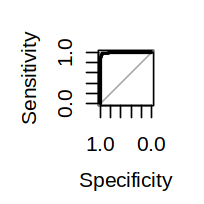

In [127]:
metric = "Accuracy"

control = trainControl(method="cv", number=5)

tunegrid = expand.grid(alpha=0, lambda = seq(0.00001, 1, length=10000))

glmnet_fit = train(y~., data = counts_train, metric = metric, method="glmnet",
                  preProcess = c("center","scale"), trControl = control)

glmnet_fit

tpred = predict(glmnet_fit, counts_train, type = "prob")
meta_data_train$classifier_score = as.numeric(tpred[,1])
youden_threshold = coords(plot.roc(meta_data_train$group, meta_data_train$classifier_score),
                         x="best", input="threshold", best.method="youden")$threshold

tpred = predict(glmnet_fit, newdata = counts_test, type="prob")
meta_data_test$classifier_score = as.numeric(tpred[,1])
roc(meta_data_test$group ~ meta_data_test$classifier_score, plot = FALSE, print.auc = TRUE)
meta_data_test$class_prediction <-
      ifelse(meta_data_test$classifier_score > youden_threshold,
             "Positive",
             "Negative"
      )
meta_data_train$class_prediction <-
      ifelse(meta_data_train$classifier_score > youden_threshold,
             "Positive",
             "Negative"
      )

confusionMatrix(factor(meta_data_test$class_prediction), factor(meta_data_test$group))
confusionMatrix(factor(meta_data_train$class_prediction), factor(meta_data_train$group))


In [128]:
print("train")
auc(meta_data_train$group ~ meta_data_train$classifier_score, plot = FALSE, print.auc = TRUE)
glmnet_ridge_auc_train = ci.auc(meta_data_train$group ~ meta_data_train$classifier_score, plot = FALSE, print.auc = TRUE)
glmnet_ridge_train =ci.coords(meta_data_train$group ~ meta_data_train$classifier_score, conf.level = 0.95, best.method="youden",
          x="best",
         ret = c("sensitivity","specificity", "accuracy","ppv","npv")) %>% data.frame()
youden=coords(roc(meta_data_train$group ~ meta_data_train$classifier_score),  best.method="youden",
          x="best")$threshold
print("test")
auc(meta_data_test$group ~ meta_data_test$classifier_score, plot = FALSE, print.auc = TRUE)
glmnet_ridge_auc_test = ci.auc(meta_data_test$group ~ meta_data_test$classifier_score, plot = FALSE, print.auc = TRUE)
glmnet_ridge_test = ci.coords(meta_data_test$group ~ meta_data_test$classifier_score,  input="threshold",
         x=youden,
         ret = c("sensitivity","specificity", "accuracy","ppv","npv")) %>% data.frame()

[1] "train"


Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



Area under the curve: 0.9958

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



[1] "test"


Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



Area under the curve: 0.9084

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



## GLMNETLasso

glmnet 

127 samples
150 predictors
  2 classes: 'Positive', 'Negative' 

Pre-processing: centered (150), scaled (150) 
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 101, 101, 103, 102, 101 
Resampling results across tuning parameters:

  alpha  lambda      Accuracy   Kappa    
  0.10   0.01830496  0.8500256  0.7000000
  0.10   0.05788536  0.8506667  0.7012821
  0.10   0.18304957  0.8423333  0.6846154
  0.55   0.01830496  0.8423333  0.6846154
  0.55   0.05788536  0.8032564  0.6059967
  0.55   0.18304957  0.7798718  0.5593577
  1.00   0.01830496  0.8346667  0.6688172
  1.00   0.05788536  0.7875385  0.5748454
  1.00   0.18304957  0.7003846  0.4003834

Accuracy was used to select the optimal model using the largest value.
The final values used for the model were alpha = 0.1 and lambda = 0.05788536.

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases




Call:
roc.formula(formula = meta_data_test$group ~ meta_data_test$classifier_score,     plot = FALSE, print.auc = TRUE)

Data: meta_data_test$classifier_score in 37 controls (meta_data_test$group Positive) > 18 cases (meta_data_test$group Negative).
Area under the curve: 0.9084

Warning message in confusionMatrix.default(factor(meta_data_test$class_prediction), :
“Levels are not in the same order for reference and data. Refactoring data to match.”


Confusion Matrix and Statistics

          Reference
Prediction Positive Negative
  Positive       30        3
  Negative        7       15
                                         
               Accuracy : 0.8182         
                 95% CI : (0.691, 0.9092)
    No Information Rate : 0.6727         
    P-Value [Acc > NIR] : 0.01259        
                                         
                  Kappa : 0.6094         
                                         
 Mcnemar's Test P-Value : 0.34278        
                                         
            Sensitivity : 0.8108         
            Specificity : 0.8333         
         Pos Pred Value : 0.9091         
         Neg Pred Value : 0.6818         
             Prevalence : 0.6727         
         Detection Rate : 0.5455         
   Detection Prevalence : 0.6000         
      Balanced Accuracy : 0.8221         
                                         
       'Positive' Class : Positive       
                    

Warning message in confusionMatrix.default(factor(meta_data_train$class_prediction), :
“Levels are not in the same order for reference and data. Refactoring data to match.”


Confusion Matrix and Statistics

          Reference
Prediction Positive Negative
  Positive       61        1
  Negative        2       63
                                          
               Accuracy : 0.9764          
                 95% CI : (0.9325, 0.9951)
    No Information Rate : 0.5039          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9527          
                                          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.9683          
            Specificity : 0.9844          
         Pos Pred Value : 0.9839          
         Neg Pred Value : 0.9692          
             Prevalence : 0.4961          
         Detection Rate : 0.4803          
   Detection Prevalence : 0.4882          
      Balanced Accuracy : 0.9763          
                                          
       'Positive' Class : Positive        


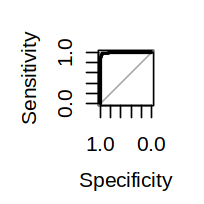

In [129]:
metric = "Accuracy"

control = trainControl(method="cv", number=5)

tunegrid = expand.grid(alpha=1, lambda = seq(0.00001, 1, length=10000))

glmnet_fit = train(y~., data = counts_train, metric = metric, method="glmnet",
                  preProcess = c("center","scale"), trControl = control)

glmnet_fit

tpred = predict(glmnet_fit, counts_train, type = "prob")
meta_data_train$classifier_score = as.numeric(tpred[,1])
youden_threshold = coords(plot.roc(meta_data_train$group, meta_data_train$classifier_score),
                         x="best", input="threshold", best.method="youden")$threshold

tpred = predict(glmnet_fit, newdata = counts_test, type="prob")
meta_data_test$classifier_score = as.numeric(tpred[,1])
roc(meta_data_test$group ~ meta_data_test$classifier_score, plot = FALSE, print.auc = TRUE)
meta_data_test$class_prediction <-
      ifelse(meta_data_test$classifier_score > youden_threshold,
             "Positive",
             "Negative"
      )
meta_data_train$class_prediction <-
      ifelse(meta_data_train$classifier_score > youden_threshold,
             "Positive",
             "Negative"
      )

confusionMatrix(factor(meta_data_test$class_prediction), factor(meta_data_test$group))
confusionMatrix(factor(meta_data_train$class_prediction), factor(meta_data_train$group))


In [130]:
print("train")
auc(meta_data_train$group ~ meta_data_train$classifier_score, plot = FALSE, print.auc = TRUE)
glmnet_lasso_auc_train =ci.auc(meta_data_train$group ~ meta_data_train$classifier_score, plot = FALSE, print.auc = TRUE)
glmnet_lasso_train =ci.coords(meta_data_train$group ~ meta_data_train$classifier_score, conf.level = 0.95, best.method="youden",
          x="best",
         ret = c("sensitivity","specificity", "accuracy","ppv","npv")) %>% data.frame()
youden=coords(roc(meta_data_train$group ~ meta_data_train$classifier_score),  best.method="youden",
          x="best")$threshold
print("test")
auc(meta_data_test$group ~ meta_data_test$classifier_score, plot = FALSE, print.auc = TRUE)
glmnet_lasso_auc_test = ci.auc(meta_data_test$group ~ meta_data_test$classifier_score, plot = FALSE, print.auc = TRUE)
glmnet_lasso_test = ci.coords(meta_data_test$group ~ meta_data_test$classifier_score,  input="threshold",
         x=youden,
         ret = c("sensitivity","specificity", "accuracy","ppv","npv")) %>% data.frame()

[1] "train"


Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



Area under the curve: 0.9958

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



[1] "test"


Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



Area under the curve: 0.9084

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



## LDA

Warning message in lda.default(x, grouping, ...):
“variables are collinear”
Warning message in lda.default(x, grouping, ...):
“variables are collinear”
Warning message in lda.default(x, grouping, ...):
“variables are collinear”
Warning message in lda.default(x, grouping, ...):
“variables are collinear”
Warning message in lda.default(x, grouping, ...):
“variables are collinear”
Warning message in lda.default(x, grouping, ...):
“variables are collinear”


Linear Discriminant Analysis 

127 samples
150 predictors
  2 classes: 'Positive', 'Negative' 

Pre-processing: centered (150), scaled (150) 
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 101, 102, 101, 101, 103 
Resampling results:

  Accuracy   Kappa    
  0.7642051  0.5290217


Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases




Call:
roc.formula(formula = meta_data_test$group ~ meta_data_test$classifier_score,     plot = FALSE, print.auc = TRUE)

Data: meta_data_test$classifier_score in 37 controls (meta_data_test$group Positive) > 18 cases (meta_data_test$group Negative).
Area under the curve: 0.7087

Warning message in confusionMatrix.default(factor(meta_data_test$class_prediction), :
“Levels are not in the same order for reference and data. Refactoring data to match.”


Confusion Matrix and Statistics

          Reference
Prediction Positive Negative
  Positive       20        6
  Negative       17       12
                                          
               Accuracy : 0.5818          
                 95% CI : (0.4411, 0.7135)
    No Information Rate : 0.6727          
    P-Value [Acc > NIR] : 0.94072         
                                          
                  Kappa : 0.1791          
                                          
 Mcnemar's Test P-Value : 0.03706         
                                          
            Sensitivity : 0.5405          
            Specificity : 0.6667          
         Pos Pred Value : 0.7692          
         Neg Pred Value : 0.4138          
             Prevalence : 0.6727          
         Detection Rate : 0.3636          
   Detection Prevalence : 0.4727          
      Balanced Accuracy : 0.6036          
                                          
       'Positive' Class : Positive        


Warning message in confusionMatrix.default(factor(meta_data_train$class_prediction), :
“Levels are not in the same order for reference and data. Refactoring data to match.”


Confusion Matrix and Statistics

          Reference
Prediction Positive Negative
  Positive       63        0
  Negative        0       64
                                     
               Accuracy : 1          
                 95% CI : (0.9714, 1)
    No Information Rate : 0.5039     
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0000     
            Specificity : 1.0000     
         Pos Pred Value : 1.0000     
         Neg Pred Value : 1.0000     
             Prevalence : 0.4961     
         Detection Rate : 0.4961     
   Detection Prevalence : 0.4961     
      Balanced Accuracy : 1.0000     
                                     
       'Positive' Class : Positive   
                                     

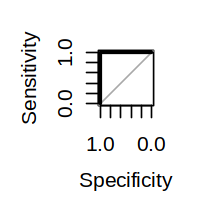

In [131]:
metric = "Accuracy"

control = trainControl(method="cv", number=5)

tunegrid = expand.grid(alpha=0, lambda = seq(0.00001, 1, length=10000))

lda_fit = train(y~., data = counts_train, metric = metric, method="lda",
                  preProcess = c("center","scale"), trControl = control)

lda_fit

tpred = predict(lda_fit, counts_train, type = "prob")
meta_data_train$classifier_score = as.numeric(tpred[,1])
youden_threshold = coords(plot.roc(meta_data_train$group, meta_data_train$classifier_score),
                         x="best", input="threshold", best.method="youden")$threshold

tpred = predict(lda_fit, newdata = counts_test, type="prob")
meta_data_test$classifier_score = as.numeric(tpred[,1])
roc(meta_data_test$group ~ meta_data_test$classifier_score, plot = FALSE, print.auc = TRUE)
meta_data_test$class_prediction <-
      ifelse(meta_data_test$classifier_score > youden_threshold,
             "Positive",
             "Negative"
      )
meta_data_train$class_prediction <-
      ifelse(meta_data_train$classifier_score > youden_threshold,
             "Positive",
             "Negative"
      )

confusionMatrix(factor(meta_data_test$class_prediction), factor(meta_data_test$group))
confusionMatrix(factor(meta_data_train$class_prediction), factor(meta_data_train$group))


In [132]:
print("train")
auc(meta_data_train$group ~ meta_data_train$classifier_score, plot = FALSE, print.auc = TRUE)
lda_auc_train = ci.auc(meta_data_train$group ~ meta_data_train$classifier_score, plot = FALSE, print.auc = TRUE)
lda_train =ci.coords(meta_data_train$group ~ meta_data_train$classifier_score, conf.level = 0.95, best.method="youden",
          x="best",
         ret = c("sensitivity","specificity", "accuracy","ppv","npv")) %>% data.frame()
youden=coords(roc(meta_data_train$group ~ meta_data_train$classifier_score),  best.method="youden",
          x="best")$threshold
print("test")
auc(meta_data_test$group ~ meta_data_test$classifier_score, plot = FALSE, print.auc = TRUE)
lda_auc_test = ci.auc(meta_data_test$group ~ meta_data_test$classifier_score, plot = FALSE, print.auc = TRUE)
lda_test = ci.coords(meta_data_test$group ~ meta_data_test$classifier_score,  input="threshold",
         x=youden,
         ret = c("sensitivity","specificity", "accuracy","ppv","npv")) %>% data.frame()

[1] "train"


Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



Area under the curve: 1

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Warning message in ci.auc.roc(roc.default(response, predictor, ci = FALSE, ...), :
“ci.auc() of a ROC curve with AUC == 1 is always 1-1 and can be misleading.”
Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Warning message in ci.coords.roc(roc(response, predictor, ci = FALSE, ...), ...):
“ci.coords() of a ROC curve with AUC == 1 is always a null interval and can be misleading.”
Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



[1] "test"


Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



Area under the curve: 0.7087

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



## RANDOM FOREST

Random Forest 

127 samples
150 predictors
  2 classes: 'Positive', 'Negative' 

Pre-processing: centered (150), scaled (150) 
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 102, 103, 101, 101, 101 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   1    0.8503590  0.7010989
   2    0.8500513  0.7008114
   3    0.8577436  0.7161960
   4    0.8417179  0.6841448
   5    0.8263333  0.6533755
   6    0.8577436  0.7161960
   7    0.8417179  0.6841448
   8    0.8417179  0.6841448
   9    0.8500513  0.7008114
  10    0.8423590  0.6854268
  11    0.8333846  0.6674781
  12    0.8417179  0.6841448
  13    0.8417179  0.6841448
  14    0.8577436  0.7161960
  15    0.8500513  0.7008114
  16    0.8333846  0.6674781
  17    0.8260256  0.6531869
  18    0.8333846  0.6674781
  19    0.8337179  0.6685715
  20    0.8333846  0.6674781
  21    0.8500513  0.7008114
  22    0.8340256  0.6687601
  23    0.8417179  0.6841448
  24    0.8420513  0.6852382
  25    0.8337

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases




Call:
roc.formula(formula = meta_data_test$group ~ meta_data_test$classifier_score,     plot = FALSE, print.auc = TRUE)

Data: meta_data_test$classifier_score in 37 controls (meta_data_test$group Positive) > 18 cases (meta_data_test$group Negative).
Area under the curve: 0.9474

Warning message in confusionMatrix.default(factor(meta_data_test$class_prediction), :
“Levels are not in the same order for reference and data. Refactoring data to match.”


Confusion Matrix and Statistics

          Reference
Prediction Positive Negative
  Positive       29        3
  Negative        8       15
                                          
               Accuracy : 0.8             
                 95% CI : (0.6703, 0.8957)
    No Information Rate : 0.6727          
    P-Value [Acc > NIR] : 0.02727         
                                          
                  Kappa : 0.576           
                                          
 Mcnemar's Test P-Value : 0.22780         
                                          
            Sensitivity : 0.7838          
            Specificity : 0.8333          
         Pos Pred Value : 0.9062          
         Neg Pred Value : 0.6522          
             Prevalence : 0.6727          
         Detection Rate : 0.5273          
   Detection Prevalence : 0.5818          
      Balanced Accuracy : 0.8086          
                                          
       'Positive' Class : Positive        


Warning message in confusionMatrix.default(factor(meta_data_train$class_prediction), :
“Levels are not in the same order for reference and data. Refactoring data to match.”


Confusion Matrix and Statistics

          Reference
Prediction Positive Negative
  Positive       63        0
  Negative        0       64
                                     
               Accuracy : 1          
                 95% CI : (0.9714, 1)
    No Information Rate : 0.5039     
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0000     
            Specificity : 1.0000     
         Pos Pred Value : 1.0000     
         Neg Pred Value : 1.0000     
             Prevalence : 0.4961     
         Detection Rate : 0.4961     
   Detection Prevalence : 0.4961     
      Balanced Accuracy : 1.0000     
                                     
       'Positive' Class : Positive   
                                     

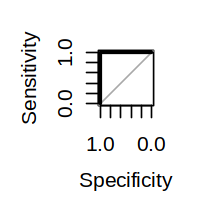

In [133]:
metric = "Accuracy"

control = trainControl(method="cv", number=5)

tunegrid <- expand.grid(.mtry = (1:75))

rf_fit = train(y~., data = counts_train, metric = metric, method="rf",
                  preProcess = c("center","scale"), trControl = control,
               tuneGrid = tunegrid)

rf_fit

tpred = predict(rf_fit, counts_train, type = "prob")
meta_data_train$classifier_score = as.numeric(tpred[,1])
youden_threshold = coords(plot.roc(meta_data_train$group, meta_data_train$classifier_score),
                         x="best", input="threshold", best.method="youden")$threshold

tpred = predict(rf_fit, newdata = counts_test, type="prob")
meta_data_test$classifier_score = as.numeric(tpred[,1])
roc(meta_data_test$group ~ meta_data_test$classifier_score, plot = FALSE, print.auc = TRUE)
meta_data_test$class_prediction <-
      ifelse(meta_data_test$classifier_score > youden_threshold,
             "Positive",
             "Negative"
      )
meta_data_train$class_prediction <-
      ifelse(meta_data_train$classifier_score > youden_threshold,
             "Positive",
             "Negative"
      )

confusionMatrix(factor(meta_data_test$class_prediction), factor(meta_data_test$group))
confusionMatrix(factor(meta_data_train$class_prediction), factor(meta_data_train$group))


In [134]:
print("train")
auc(meta_data_train$group ~ meta_data_train$classifier_score, plot = FALSE, print.auc = TRUE)
rf_auc_train = ci.auc(meta_data_train$group ~ meta_data_train$classifier_score, plot = FALSE, print.auc = TRUE)
rf_train =ci.coords(meta_data_train$group ~ meta_data_train$classifier_score, conf.level = 0.95, best.method="youden",
          x="best",
         ret = c("sensitivity","specificity", "accuracy","ppv","npv")) %>% data.frame()
youden=coords(roc(meta_data_train$group ~ meta_data_train$classifier_score),  best.method="youden",
          x="best")$threshold
print("test")
auc(meta_data_test$group ~ meta_data_test$classifier_score, plot = FALSE, print.auc = TRUE)
rf_test_auc =ci.auc(meta_data_test$group ~ meta_data_test$classifier_score, plot = FALSE, print.auc = TRUE)
rf_test = ci.coords(meta_data_test$group ~ meta_data_test$classifier_score,  input="threshold",
         x=youden,
         ret = c("sensitivity","specificity", "accuracy","ppv","npv")) %>% data.frame()

[1] "train"


Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



Area under the curve: 1

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Warning message in ci.auc.roc(roc.default(response, predictor, ci = FALSE, ...), :
“ci.auc() of a ROC curve with AUC == 1 is always 1-1 and can be misleading.”
Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Warning message in ci.coords.roc(roc(response, predictor, ci = FALSE, ...), ...):
“ci.coords() of a ROC curve with AUC == 1 is always a null interval and can be misleading.”
Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



[1] "test"


Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



Area under the curve: 0.9474

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



## SVMLin

Support Vector Machines with Linear Kernel 

127 samples
150 predictors
  2 classes: 'Positive', 'Negative' 

Pre-processing: centered (150), scaled (150) 
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 101, 103, 101, 102, 101 
Resampling results across tuning parameters:

  C            Accuracy   Kappa    
  0.000010000  0.5520000  0.1025974
  0.002011992  0.8177179  0.6356148
  0.004013984  0.8257179  0.6512821
  0.006015976  0.8180256  0.6358974
  0.008017968  0.8103333  0.6205128
  0.010019960  0.8023077  0.6042295
  0.012021952  0.8023077  0.6042295
  0.014023944  0.8183333  0.6362808
  0.016025936  0.8176923  0.6349988
  0.018027928  0.8176923  0.6349988
  0.020029920  0.8253846  0.6503834
  0.022031912  0.8183333  0.6362808
  0.024033904  0.8260256  0.6516654
  0.026035896  0.8260256  0.6516654
  0.028037888  0.8263333  0.6521505
  0.030039880  0.8340256  0.6675352
  0.032041872  0.8336923  0.6668409
  0.034043864  0.8340256  0.6675352
  0.036045856  0.8180000  

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases




Call:
roc.formula(formula = meta_data_test$group ~ meta_data_test$classifier_score,     plot = FALSE, print.auc = TRUE)

Data: meta_data_test$classifier_score in 37 controls (meta_data_test$group Positive) > 18 cases (meta_data_test$group Negative).
Area under the curve: 0.8844

Warning message in confusionMatrix.default(factor(meta_data_test$class_prediction), :
“Levels are not in the same order for reference and data. Refactoring data to match.”


Confusion Matrix and Statistics

          Reference
Prediction Positive Negative
  Positive       32        6
  Negative        5       12
                                          
               Accuracy : 0.8             
                 95% CI : (0.6703, 0.8957)
    No Information Rate : 0.6727          
    P-Value [Acc > NIR] : 0.02727         
                                          
                  Kappa : 0.5392          
                                          
 Mcnemar's Test P-Value : 1.00000         
                                          
            Sensitivity : 0.8649          
            Specificity : 0.6667          
         Pos Pred Value : 0.8421          
         Neg Pred Value : 0.7059          
             Prevalence : 0.6727          
         Detection Rate : 0.5818          
   Detection Prevalence : 0.6909          
      Balanced Accuracy : 0.7658          
                                          
       'Positive' Class : Positive        


Warning message in confusionMatrix.default(factor(meta_data_train$class_prediction), :
“Levels are not in the same order for reference and data. Refactoring data to match.”


Confusion Matrix and Statistics

          Reference
Prediction Positive Negative
  Positive       63        3
  Negative        0       61
                                          
               Accuracy : 0.9764          
                 95% CI : (0.9325, 0.9951)
    No Information Rate : 0.5039          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9528          
                                          
 Mcnemar's Test P-Value : 0.2482          
                                          
            Sensitivity : 1.0000          
            Specificity : 0.9531          
         Pos Pred Value : 0.9545          
         Neg Pred Value : 1.0000          
             Prevalence : 0.4961          
         Detection Rate : 0.4961          
   Detection Prevalence : 0.5197          
      Balanced Accuracy : 0.9766          
                                          
       'Positive' Class : Positive        


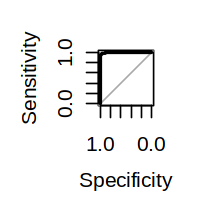

In [135]:
metric = "Accuracy"

control = trainControl(method="cv", number=5, classProbs = TRUE)

tunegrid <- expand.grid(C = seq(0.00001, 2, length = 1000))

svmlin_fit = train(y~., data = counts_train, metric = metric, method="svmLinear",
                  preProcess = c("center","scale"), trControl = control,
               tuneGrid = tunegrid)

svmlin_fit

tpred = predict(svmlin_fit, counts_train, type = "prob")
meta_data_train$classifier_score = as.numeric(tpred[,1])
youden_threshold = coords(plot.roc(meta_data_train$group, meta_data_train$classifier_score),
                         x="best", input="threshold", best.method="youden")$threshold

tpred = predict(svmlin_fit, newdata = counts_test, type="prob")
meta_data_test$classifier_score = as.numeric(tpred[,1])
roc(meta_data_test$group ~ meta_data_test$classifier_score, plot = FALSE, print.auc = TRUE)
meta_data_test$class_prediction <-
      ifelse(meta_data_test$classifier_score > youden_threshold,
             "Positive",
             "Negative"
      )
meta_data_train$class_prediction <-
      ifelse(meta_data_train$classifier_score > youden_threshold,
             "Positive",
             "Negative"
      )

confusionMatrix(factor(meta_data_test$class_prediction), factor(meta_data_test$group))
confusionMatrix(factor(meta_data_train$class_prediction), factor(meta_data_train$group))


In [136]:
print("train")
auc(meta_data_train$group ~ meta_data_train$classifier_score, plot = FALSE, print.auc = TRUE)
svm_lin_auc_train = ci.auc(meta_data_train$group ~ meta_data_train$classifier_score, plot = FALSE, print.auc = TRUE)
svm_lin_train =ci.coords(meta_data_train$group ~ meta_data_train$classifier_score, conf.level = 0.95, best.method="youden",
          x="best",
         ret = c("sensitivity","specificity", "accuracy","ppv","npv")) %>% data.frame()
youden=coords(roc(meta_data_train$group ~ meta_data_train$classifier_score),  best.method="youden",
          x="best")$threshold
print("test")
auc(meta_data_test$group ~ meta_data_test$classifier_score, plot = FALSE, print.auc = TRUE)
svm_lin_auc_test = ci.auc(meta_data_test$group ~ meta_data_test$classifier_score, plot = FALSE, print.auc = TRUE)
svm_lin_test = ci.coords(meta_data_test$group ~ meta_data_test$classifier_score,  input="threshold",
         x=youden,
         ret = c("sensitivity","specificity", "accuracy","ppv","npv")) %>% data.frame()

[1] "train"


Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



Area under the curve: 0.9978

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



[1] "test"


Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



Area under the curve: 0.8844

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



## SVM RAD

Warning message:
“model fit failed for Fold1: C=0.000000, sigma=0.010 Error in .local(x, ...) : 
  No Support Vectors found. You may want to change your parameters
”
Warning message:
“model fit failed for Fold1: C=0.000000, sigma=0.015 Error in .local(x, ...) : 
  No Support Vectors found. You may want to change your parameters
”
Warning message:
“model fit failed for Fold1: C=0.000000, sigma=0.200 Error in .local(x, ...) : 
  No Support Vectors found. You may want to change your parameters
”
Warning message:
“model fit failed for Fold2: C=0.000000, sigma=0.010 Error in .local(x, ...) : 
  No Support Vectors found. You may want to change your parameters
”
Warning message:
“model fit failed for Fold2: C=0.000000, sigma=0.015 Error in .local(x, ...) : 
  No Support Vectors found. You may want to change your parameters
”


maximum number of iterations reached 5.574153e-05 1.148217e-08

Warning message:
“model fit failed for Fold2: C=0.000000, sigma=0.200 Error in .local(x, ...) : 
  No Support Vectors found. You may want to change your parameters
”


maximum number of iterations reached 1.02374e-05 1.122885e-11maximum number of iterations reached 1.070506e-05 1.224565e-11maximum number of iterations reached 1.000862e-05 1.029549e-11maximum number of iterations reached 1.011017e-05 1.062123e-11maximum number of iterations reached 1.038665e-05 1.001949e-11maximum number of iterations reached 1.225493e-05 1.707995e-11maximum number of iterations reached 1.163046e-05 1.336115e-11maximum number of iterations reached 1.156945e-05 1.272343e-11maximum number of iterations reached 1.330322e-05 1.978845e-11maximum number of iterations reached 1.347607e-05 2.067868e-11maximum number of iterations reached 1.391681e-05 2.147404e-11maximum number of iterations reached 1.460667e-05 2.291184e-11maximum number of iterations reached 1.503584e-05 2.359979e-11maximum number of iterations reached 1.534532e-05 2.561473e-11maximum number of iterations reached 1.64934e-05 2.658973e-11maximum number of iterations reached 1.58318e-05 2.740641e-11maximum num

Warning message:
“model fit failed for Fold3: C=0.000000, sigma=0.010 Error in .local(x, ...) : 
  No Support Vectors found. You may want to change your parameters
”
Warning message:
“model fit failed for Fold3: C=0.000000, sigma=0.015 Error in .local(x, ...) : 
  No Support Vectors found. You may want to change your parameters
”


maximum number of iterations reached 0.0001535627 1.714683e-07

Warning message:
“model fit failed for Fold3: C=0.000000, sigma=0.200 Error in .local(x, ...) : 
  No Support Vectors found. You may want to change your parameters
”


maximum number of iterations reached 1.018019e-05 1.556982e-11maximum number of iterations reached 1.111504e-05 1.872663e-11maximum number of iterations reached 1.063304e-05 1.851658e-11maximum number of iterations reached 1.182301e-05 2.261979e-11maximum number of iterations reached 1.147539e-05 2.116907e-11maximum number of iterations reached 1.293099e-05 2.675049e-11maximum number of iterations reached 1.42054e-05 3.055128e-11maximum number of iterations reached 1.467742e-05 3.229245e-11maximum number of iterations reached 1.375568e-05 3.020539e-11maximum number of iterations reached 1.532525e-05 3.514961e-11maximum number of iterations reached 1.432144e-05 3.404416e-11maximum number of iterations reached 1.47585e-05 3.552092e-11maximum number of iterations reached 1.761231e-05 4.888556e-11maximum number of iterations reached 1.869976e-05 5.239525e-11maximum number of iterations reached 1.939404e-05 5.65703e-11maximum number of iterations reached 1.385933e-05 5.273482e-11maximum num

Warning message:
“model fit failed for Fold4: C=0.000000, sigma=0.010 Error in .local(x, ...) : 
  No Support Vectors found. You may want to change your parameters
”
Warning message:
“model fit failed for Fold4: C=0.000000, sigma=0.015 Error in .local(x, ...) : 
  No Support Vectors found. You may want to change your parameters
”
Warning message:
“model fit failed for Fold4: C=0.000000, sigma=0.200 Error in .local(x, ...) : 
  No Support Vectors found. You may want to change your parameters
”
Warning message:
“model fit failed for Fold5: C=0.000000, sigma=0.010 Error in .local(x, ...) : 
  No Support Vectors found. You may want to change your parameters
”
Warning message:
“model fit failed for Fold5: C=0.000000, sigma=0.015 Error in .local(x, ...) : 
  No Support Vectors found. You may want to change your parameters
”
Warning message:
“model fit failed for Fold5: C=0.000000, sigma=0.200 Error in .local(x, ...) : 
  No Support Vectors found. You may want to change your parameters
”
Warn

Support Vector Machines with Radial Basis Function Kernel 

127 samples
150 predictors
  2 classes: 'Positive', 'Negative' 

Pre-processing: centered (150), scaled (150) 
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 101, 102, 102, 101, 102 
Resampling results across tuning parameters:

  C            sigma  Accuracy   Kappa       
  0.000000000  0.010        NaN           NaN
  0.000000000  0.015        NaN           NaN
  0.000000000  0.200        NaN           NaN
  0.002002002  0.010  0.6080000   0.225698212
  0.002002002  0.015  0.5760000   0.163803742
  0.002002002  0.200  0.4880000   0.000000000
  0.004004004  0.010  0.6080000   0.225895638
  0.004004004  0.015  0.5760000   0.163803742
  0.004004004  0.200  0.4880000   0.000000000
  0.006006006  0.010  0.6160000   0.241369024
  0.006006006  0.015  0.5760000   0.163803742
  0.006006006  0.200  0.4880000   0.000000000
  0.008008008  0.010  0.6160000   0.241369024
  0.008008008  0.015  0.5760000   0.163803742
  0.0

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases




Call:
roc.formula(formula = meta_data_test$group ~ meta_data_test$classifier_score,     plot = FALSE, print.auc = TRUE)

Data: meta_data_test$classifier_score in 37 controls (meta_data_test$group Positive) > 18 cases (meta_data_test$group Negative).
Area under the curve: 0.9039

Warning message in confusionMatrix.default(factor(meta_data_test$class_prediction), :
“Levels are not in the same order for reference and data. Refactoring data to match.”


Confusion Matrix and Statistics

          Reference
Prediction Positive Negative
  Positive       30        2
  Negative        7       16
                                         
               Accuracy : 0.8364         
                 95% CI : (0.712, 0.9223)
    No Information Rate : 0.6727         
    P-Value [Acc > NIR] : 0.00521        
                                         
                  Kappa : 0.6531         
                                         
 Mcnemar's Test P-Value : 0.18242        
                                         
            Sensitivity : 0.8108         
            Specificity : 0.8889         
         Pos Pred Value : 0.9375         
         Neg Pred Value : 0.6957         
             Prevalence : 0.6727         
         Detection Rate : 0.5455         
   Detection Prevalence : 0.5818         
      Balanced Accuracy : 0.8498         
                                         
       'Positive' Class : Positive       
                    

Warning message in confusionMatrix.default(factor(meta_data_train$class_prediction), :
“Levels are not in the same order for reference and data. Refactoring data to match.”


Confusion Matrix and Statistics

          Reference
Prediction Positive Negative
  Positive       57        5
  Negative        6       59
                                         
               Accuracy : 0.9134         
                 95% CI : (0.8503, 0.956)
    No Information Rate : 0.5039         
    P-Value [Acc > NIR] : <2e-16         
                                         
                  Kappa : 0.8267         
                                         
 Mcnemar's Test P-Value : 1              
                                         
            Sensitivity : 0.9048         
            Specificity : 0.9219         
         Pos Pred Value : 0.9194         
         Neg Pred Value : 0.9077         
             Prevalence : 0.4961         
         Detection Rate : 0.4488         
   Detection Prevalence : 0.4882         
      Balanced Accuracy : 0.9133         
                                         
       'Positive' Class : Positive       
                    

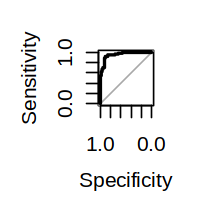

In [137]:
metric = "Accuracy"

control = trainControl(method="cv", number=5, classProbs = TRUE)

 
    tunegrid <- expand.grid(C = seq(0, 2, length = 1000),
                           sigma = c(.01, .015, 0.2))

svmlin_fit = train(y~., data = counts_train, metric = metric, method="svmRadial",
                  preProcess = c("center","scale"), trControl = control,
               tuneGrid = tunegrid)

svmlin_fit

tpred = predict(svmlin_fit, counts_train, type = "prob")
meta_data_train$classifier_score = as.numeric(tpred[,1])
youden_threshold = coords(plot.roc(meta_data_train$group, meta_data_train$classifier_score),
                         x="best", input="threshold", best.method="youden")$threshold

tpred = predict(svmlin_fit, newdata = counts_test, type="prob")
meta_data_test$classifier_score = as.numeric(tpred[,1])
roc(meta_data_test$group ~ meta_data_test$classifier_score, plot = FALSE, print.auc = TRUE)
meta_data_test$class_prediction <-
      ifelse(meta_data_test$classifier_score > youden_threshold,
             "Positive",
             "Negative"
      )
meta_data_train$class_prediction <-
      ifelse(meta_data_train$classifier_score > youden_threshold,
             "Positive",
             "Negative"
      )

confusionMatrix(factor(meta_data_test$class_prediction), factor(meta_data_test$group))
confusionMatrix(factor(meta_data_train$class_prediction), factor(meta_data_train$group))


In [138]:
print("train")
auc(meta_data_train$group ~ meta_data_train$classifier_score, plot = FALSE, print.auc = TRUE)
svm_rad_auc_train =ci.auc(meta_data_train$group ~ meta_data_train$classifier_score, plot = FALSE, print.auc = TRUE)
svm_rad_train =ci.coords(meta_data_train$group ~ meta_data_train$classifier_score, conf.level = 0.95, best.method="youden",
          x="best",
         ret = c("sensitivity","specificity", "accuracy","ppv","npv")) %>% data.frame()
youden=coords(roc(meta_data_train$group ~ meta_data_train$classifier_score),  best.method="youden",
          x="best")$threshold
print("test")
auc(meta_data_test$group ~ meta_data_test$classifier_score, plot = FALSE, print.auc = TRUE)
svm_rad_auc_test = ci.auc(meta_data_test$group ~ meta_data_test$classifier_score, plot = FALSE, print.auc = TRUE)
svm_rad_test = ci.coords(meta_data_test$group ~ meta_data_test$classifier_score,  input="threshold",
         x=youden,
         ret = c("sensitivity","specificity", "accuracy","ppv","npv")) %>% data.frame()

[1] "train"


Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



Area under the curve: 0.9568

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



[1] "test"


Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



Area under the curve: 0.9039

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



## NB

Warning message:
“model fit failed for Fold1: fL=0, usekernel= TRUE, adjust=0 Error in density.default(xx, ...) : 'bw' is not positive.
”
Warning message:
“model fit failed for Fold1: fL=1, usekernel= TRUE, adjust=0 Error in density.default(xx, ...) : 'bw' is not positive.
”
Warning message:
“model fit failed for Fold1: fL=2, usekernel= TRUE, adjust=0 Error in density.default(xx, ...) : 'bw' is not positive.
”
Warning message:
“model fit failed for Fold1: fL=3, usekernel= TRUE, adjust=0 Error in density.default(xx, ...) : 'bw' is not positive.
”
Warning message:
“model fit failed for Fold1: fL=4, usekernel= TRUE, adjust=0 Error in density.default(xx, ...) : 'bw' is not positive.
”
Warning message:
“model fit failed for Fold1: fL=5, usekernel= TRUE, adjust=0 Error in density.default(xx, ...) : 'bw' is not positive.
”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all clas

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message i

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning mess

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning messa

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning messag

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning mes

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message i

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning mess

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning messa

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning messag

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning mes

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message i

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning mess

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning messa

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning messag

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning mes

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message i

Warning message:
“model fit failed for Fold2: fL=2, usekernel= TRUE, adjust=0 Error in density.default(xx, ...) : 'bw' is not positive.
”
Warning message:
“model fit failed for Fold2: fL=3, usekernel= TRUE, adjust=0 Error in density.default(xx, ...) : 'bw' is not positive.
”
Warning message:
“model fit failed for Fold2: fL=4, usekernel= TRUE, adjust=0 Error in density.default(xx, ...) : 'bw' is not positive.
”
Warning message:
“model fit failed for Fold2: fL=5, usekernel= TRUE, adjust=0 Error in density.default(xx, ...) : 'bw' is not positive.
”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probab

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning messa

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning mess

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message i

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning mes

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning messag

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning messa

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning mess

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message i

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning mes

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning messag

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning messa

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning mess

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message i

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning mes

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning messag

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in 

Warning message:
“model fit failed for Fold3: fL=4, usekernel= TRUE, adjust=0 Error in density.default(xx, ...) : 'bw' is not positive.
”
Warning message:
“model fit failed for Fold3: fL=5, usekernel= TRUE, adjust=0 Error in density.default(xx, ...) : 'bw' is not positive.
”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning messa

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning mes

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning mess

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning messag

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning messag

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning mess

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning mes

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning messa

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message i

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message i

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning messa

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning mes

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning mess

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning messag

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning messag

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning mes

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message i

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning mess

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning messa

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning messag

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning mes

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message i

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning mess

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning messa

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning messag

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning mes

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message i

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning mess

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning messa

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 11”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning messag

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 12”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 13”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 14”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 15”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 16”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 17”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 18”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 19”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 20”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 21”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 22”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 23”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 24”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 25”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 26”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing 

Naive Bayes 

127 samples
150 predictors
  2 classes: 'Positive', 'Negative' 

Pre-processing: centered (150), scaled (150) 
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 101, 101, 102, 103, 101 
Resampling results across tuning parameters:

  fL  usekernel  adjust  Accuracy   Kappa    
  0   FALSE      0       0.7949487  0.5891232
  0   FALSE      1       0.7949487  0.5891232
  0   FALSE      2       0.7949487  0.5891232
  0   FALSE      3       0.7949487  0.5891232
  0   FALSE      4       0.7949487  0.5891232
  0   FALSE      5       0.7949487  0.5891232
  0    TRUE      0             NaN        NaN
  0    TRUE      1       0.8183333  0.6362808
  0    TRUE      2       0.8343590  0.6683321
  0    TRUE      3       0.8109744  0.6211745
  0    TRUE      4       0.7795897  0.5573094
  0    TRUE      5       0.7562051  0.5098305
  1   FALSE      0       0.7949487  0.5891232
  1   FALSE      1       0.7949487  0.5891232
  1   FALSE      2       0.7949487  0.5891232
  1  

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in 

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 84”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 85”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 86”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 87”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 88”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 89”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 90”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 91”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 92”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 93”
Warning me

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 39”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 40”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 41”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 42”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 43”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 44”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 45”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 46”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 47”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 48”
Warning me


Call:
roc.formula(formula = meta_data_test$group ~ meta_data_test$classifier_score,     plot = FALSE, print.auc = TRUE)

Data: meta_data_test$classifier_score in 37 controls (meta_data_test$group Positive) > 18 cases (meta_data_test$group Negative).
Area under the curve: 0.9444

Warning message in confusionMatrix.default(factor(meta_data_test$class_prediction), :
“Levels are not in the same order for reference and data. Refactoring data to match.”


Confusion Matrix and Statistics

          Reference
Prediction Positive Negative
  Positive       32        2
  Negative        5       16
                                          
               Accuracy : 0.8727          
                 95% CI : (0.7552, 0.9473)
    No Information Rate : 0.6727          
    P-Value [Acc > NIR] : 0.000615        
                                          
                  Kappa : 0.7228          
                                          
 Mcnemar's Test P-Value : 0.449692        
                                          
            Sensitivity : 0.8649          
            Specificity : 0.8889          
         Pos Pred Value : 0.9412          
         Neg Pred Value : 0.7619          
             Prevalence : 0.6727          
         Detection Rate : 0.5818          
   Detection Prevalence : 0.6182          
      Balanced Accuracy : 0.8769          
                                          
       'Positive' Class : Positive        


Warning message in confusionMatrix.default(factor(meta_data_train$class_prediction), :
“Levels are not in the same order for reference and data. Refactoring data to match.”


Confusion Matrix and Statistics

          Reference
Prediction Positive Negative
  Positive       58       10
  Negative        5       54
                                          
               Accuracy : 0.8819          
                 95% CI : (0.8127, 0.9324)
    No Information Rate : 0.5039          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.7639          
                                          
 Mcnemar's Test P-Value : 0.3017          
                                          
            Sensitivity : 0.9206          
            Specificity : 0.8438          
         Pos Pred Value : 0.8529          
         Neg Pred Value : 0.9153          
             Prevalence : 0.4961          
         Detection Rate : 0.4567          
   Detection Prevalence : 0.5354          
      Balanced Accuracy : 0.8822          
                                          
       'Positive' Class : Positive        


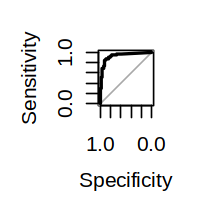

In [139]:
metric = "Accuracy"

control = trainControl(method="cv", number=5, classProbs = TRUE)

 tunegrid <- expand.grid(fL = 0:5,
                            usekernel = c(TRUE,FALSE),
                            adjust = seq(0, 5, by = 1)
                            )
nb_fit = train(y~., data = counts_train, metric = metric, method="nb",
                  preProcess = c("center","scale"), trControl = control,
               tuneGrid = tunegrid)

nb_fit

tpred = predict(nb_fit, counts_train, type = "prob")
meta_data_train$classifier_score = as.numeric(tpred[,1])
youden_threshold = coords(plot.roc(meta_data_train$group, meta_data_train$classifier_score),
                         x="best", input="threshold", best.method="youden")$threshold

tpred = predict(nb_fit, newdata = counts_test, type="prob")
meta_data_test$classifier_score = as.numeric(tpred[,1])
roc(meta_data_test$group ~ meta_data_test$classifier_score, plot = FALSE, print.auc = TRUE)
meta_data_test$class_prediction <-
      ifelse(meta_data_test$classifier_score > youden_threshold,
             "Positive",
             "Negative"
      )
meta_data_train$class_prediction <-
      ifelse(meta_data_train$classifier_score > youden_threshold,
             "Positive",
             "Negative"
      )

confusionMatrix(factor(meta_data_test$class_prediction), factor(meta_data_test$group))
confusionMatrix(factor(meta_data_train$class_prediction), factor(meta_data_train$group))


In [140]:
print("train")
auc(meta_data_train$group ~ meta_data_train$classifier_score, plot = FALSE, print.auc = TRUE)
nb_auc_train = ci.auc(meta_data_train$group ~ meta_data_train$classifier_score, plot = FALSE, print.auc = TRUE)
nb_train =ci.coords(meta_data_train$group ~ meta_data_train$classifier_score, conf.level = 0.95, best.method="youden",
          x="best",
         ret = c("sensitivity","specificity", "accuracy","ppv","npv")) %>% data.frame()
youden=coords(roc(meta_data_train$group ~ meta_data_train$classifier_score),  best.method="youden",
          x="best")$threshold
print("test")
auc(meta_data_test$group ~ meta_data_test$classifier_score, plot = FALSE, print.auc = TRUE)
nb_auc_test = ci.auc(meta_data_test$group ~ meta_data_test$classifier_score, plot = FALSE, print.auc = TRUE)
nb_test = ci.coords(meta_data_test$group ~ meta_data_test$classifier_score,  input="threshold",
         x=youden,
         ret = c("sensitivity","specificity", "accuracy","ppv","npv")) %>% data.frame()

[1] "train"


Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



Area under the curve: 0.9345

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



[1] "test"


Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



Area under the curve: 0.9444

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



## KNN

Warning message in knn3Train(train = structure(c(1.46223238569924, 0.736886816948757, :
“k = 103 exceeds number 101 of patterns”
Warning message in knn3Train(train = structure(c(1.46223238569924, 0.736886816948757, :
“k = 103 exceeds number 101 of patterns”
Warning message in knn3Train(train = structure(c(1.46223238569924, 0.736886816948757, :
“k = 105 exceeds number 101 of patterns”
Warning message in knn3Train(train = structure(c(1.46223238569924, 0.736886816948757, :
“k = 105 exceeds number 101 of patterns”
Warning message in knn3Train(train = structure(c(1.46223238569924, 0.736886816948757, :
“k = 107 exceeds number 101 of patterns”
Warning message in knn3Train(train = structure(c(1.46223238569924, 0.736886816948757, :
“k = 107 exceeds number 101 of patterns”
Warning message in knn3Train(train = structure(c(1.46223238569924, 0.736886816948757, :
“k = 109 exceeds number 101 of patterns”
Warning message in knn3Train(train = structure(c(1.46223238569924, 0.736886816948757, :
“k = 109 

Warning message in knn3Train(train = structure(c(1.46223238569924, 0.736886816948757, :
“k = 167 exceeds number 101 of patterns”
Warning message in knn3Train(train = structure(c(1.46223238569924, 0.736886816948757, :
“k = 167 exceeds number 101 of patterns”
Warning message in knn3Train(train = structure(c(1.46223238569924, 0.736886816948757, :
“k = 169 exceeds number 101 of patterns”
Warning message in knn3Train(train = structure(c(1.46223238569924, 0.736886816948757, :
“k = 169 exceeds number 101 of patterns”
Warning message in knn3Train(train = structure(c(1.46223238569924, 0.736886816948757, :
“k = 171 exceeds number 101 of patterns”
Warning message in knn3Train(train = structure(c(1.46223238569924, 0.736886816948757, :
“k = 171 exceeds number 101 of patterns”
Warning message in knn3Train(train = structure(c(1.46223238569924, 0.736886816948757, :
“k = 173 exceeds number 101 of patterns”
Warning message in knn3Train(train = structure(c(1.46223238569924, 0.736886816948757, :
“k = 173 

Warning message in knn3Train(train = structure(c(0.804883362761963, -0.92465705908898, :
“k = 129 exceeds number 101 of patterns”
Warning message in knn3Train(train = structure(c(0.804883362761963, -0.92465705908898, :
“k = 129 exceeds number 101 of patterns”
Warning message in knn3Train(train = structure(c(0.804883362761963, -0.92465705908898, :
“k = 131 exceeds number 101 of patterns”
Warning message in knn3Train(train = structure(c(0.804883362761963, -0.92465705908898, :
“k = 131 exceeds number 101 of patterns”
Warning message in knn3Train(train = structure(c(0.804883362761963, -0.92465705908898, :
“k = 133 exceeds number 101 of patterns”
Warning message in knn3Train(train = structure(c(0.804883362761963, -0.92465705908898, :
“k = 133 exceeds number 101 of patterns”
Warning message in knn3Train(train = structure(c(0.804883362761963, -0.92465705908898, :
“k = 135 exceeds number 101 of patterns”
Warning message in knn3Train(train = structure(c(0.804883362761963, -0.92465705908898, :
“

Warning message in knn3Train(train = structure(c(0.804883362761963, -0.92465705908898, :
“k = 193 exceeds number 101 of patterns”
Warning message in knn3Train(train = structure(c(0.804883362761963, -0.92465705908898, :
“k = 193 exceeds number 101 of patterns”
Warning message in knn3Train(train = structure(c(0.804883362761963, -0.92465705908898, :
“k = 195 exceeds number 101 of patterns”
Warning message in knn3Train(train = structure(c(0.804883362761963, -0.92465705908898, :
“k = 195 exceeds number 101 of patterns”
Warning message in knn3Train(train = structure(c(0.804883362761963, -0.92465705908898, :
“k = 197 exceeds number 101 of patterns”
Warning message in knn3Train(train = structure(c(0.804883362761963, -0.92465705908898, :
“k = 197 exceeds number 101 of patterns”
Warning message in knn3Train(train = structure(c(0.804883362761963, -0.92465705908898, :
“k = 199 exceeds number 101 of patterns”
Warning message in knn3Train(train = structure(c(0.804883362761963, -0.92465705908898, :
“

Warning message in knn3Train(train = structure(c(1.51003643415704, 0.776610772925049, :
“k = 155 exceeds number 101 of patterns”
Warning message in knn3Train(train = structure(c(1.51003643415704, 0.776610772925049, :
“k = 155 exceeds number 101 of patterns”
Warning message in knn3Train(train = structure(c(1.51003643415704, 0.776610772925049, :
“k = 157 exceeds number 101 of patterns”
Warning message in knn3Train(train = structure(c(1.51003643415704, 0.776610772925049, :
“k = 157 exceeds number 101 of patterns”
Warning message in knn3Train(train = structure(c(1.51003643415704, 0.776610772925049, :
“k = 159 exceeds number 101 of patterns”
Warning message in knn3Train(train = structure(c(1.51003643415704, 0.776610772925049, :
“k = 159 exceeds number 101 of patterns”
Warning message in knn3Train(train = structure(c(1.51003643415704, 0.776610772925049, :
“k = 161 exceeds number 101 of patterns”
Warning message in knn3Train(train = structure(c(1.51003643415704, 0.776610772925049, :
“k = 161 

Warning message in knn3Train(train = structure(c(1.52369184183397, -1.03800060163822, :
“k = 117 exceeds number 102 of patterns”
Warning message in knn3Train(train = structure(c(1.52369184183397, -1.03800060163822, :
“k = 117 exceeds number 102 of patterns”
Warning message in knn3Train(train = structure(c(1.52369184183397, -1.03800060163822, :
“k = 119 exceeds number 102 of patterns”
Warning message in knn3Train(train = structure(c(1.52369184183397, -1.03800060163822, :
“k = 119 exceeds number 102 of patterns”
Warning message in knn3Train(train = structure(c(1.52369184183397, -1.03800060163822, :
“k = 121 exceeds number 102 of patterns”
Warning message in knn3Train(train = structure(c(1.52369184183397, -1.03800060163822, :
“k = 121 exceeds number 102 of patterns”
Warning message in knn3Train(train = structure(c(1.52369184183397, -1.03800060163822, :
“k = 123 exceeds number 102 of patterns”
Warning message in knn3Train(train = structure(c(1.52369184183397, -1.03800060163822, :
“k = 123 

Warning message in knn3Train(train = structure(c(1.52369184183397, -1.03800060163822, :
“k = 181 exceeds number 102 of patterns”
Warning message in knn3Train(train = structure(c(1.52369184183397, -1.03800060163822, :
“k = 181 exceeds number 102 of patterns”
Warning message in knn3Train(train = structure(c(1.52369184183397, -1.03800060163822, :
“k = 183 exceeds number 102 of patterns”
Warning message in knn3Train(train = structure(c(1.52369184183397, -1.03800060163822, :
“k = 183 exceeds number 102 of patterns”
Warning message in knn3Train(train = structure(c(1.52369184183397, -1.03800060163822, :
“k = 185 exceeds number 102 of patterns”
Warning message in knn3Train(train = structure(c(1.52369184183397, -1.03800060163822, :
“k = 185 exceeds number 102 of patterns”
Warning message in knn3Train(train = structure(c(1.52369184183397, -1.03800060163822, :
“k = 187 exceeds number 102 of patterns”
Warning message in knn3Train(train = structure(c(1.52369184183397, -1.03800060163822, :
“k = 187 

Warning message in knn3Train(train = structure(c(1.46094582492628, 0.75016512779264, :
“k = 145 exceeds number 103 of patterns”
Warning message in knn3Train(train = structure(c(1.46094582492628, 0.75016512779264, :
“k = 145 exceeds number 103 of patterns”
Warning message in knn3Train(train = structure(c(1.46094582492628, 0.75016512779264, :
“k = 147 exceeds number 103 of patterns”
Warning message in knn3Train(train = structure(c(1.46094582492628, 0.75016512779264, :
“k = 147 exceeds number 103 of patterns”
Warning message in knn3Train(train = structure(c(1.46094582492628, 0.75016512779264, :
“k = 149 exceeds number 103 of patterns”
Warning message in knn3Train(train = structure(c(1.46094582492628, 0.75016512779264, :
“k = 149 exceeds number 103 of patterns”
Warning message in knn3Train(train = structure(c(1.46094582492628, 0.75016512779264, :
“k = 151 exceeds number 103 of patterns”
Warning message in knn3Train(train = structure(c(1.46094582492628, 0.75016512779264, :
“k = 151 exceeds 

k-Nearest Neighbors 

127 samples
150 predictors
  2 classes: 'Positive', 'Negative' 

Pre-processing: centered (150), scaled (150) 
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 101, 101, 101, 102, 103 
Resampling results across tuning parameters:

  k    Accuracy   Kappa       
    5  0.8273077   0.654229533
    7  0.8346667   0.669230769
    9  0.8430000   0.685897436
   11  0.8513333   0.702564103
   13  0.8590256   0.717948718
   15  0.8423590   0.684615385
   17  0.8500513   0.700000000
   19  0.8583846   0.716666667
   21  0.8583846   0.716666667
   23  0.8583846   0.716666667
   25  0.8500513   0.700000000
   27  0.8500513   0.700000000
   29  0.8583846   0.716666667
   31  0.8590256   0.717948718
   33  0.8506923   0.701282051
   35  0.8430000   0.685897436
   37  0.8353077   0.670512821
   39  0.8346667   0.669230769
   41  0.8430000   0.685897436
   43  0.8350000   0.669614148
   45  0.8273077   0.654229533
   47  0.8196154   0.638844917
   49  0.8196154   0

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases




Call:
roc.formula(formula = meta_data_test$group ~ meta_data_test$classifier_score,     plot = FALSE, print.auc = TRUE)

Data: meta_data_test$classifier_score in 37 controls (meta_data_test$group Positive) > 18 cases (meta_data_test$group Negative).
Area under the curve: 0.9339

Warning message in confusionMatrix.default(factor(meta_data_test$class_prediction), :
“Levels are not in the same order for reference and data. Refactoring data to match.”


Confusion Matrix and Statistics

          Reference
Prediction Positive Negative
  Positive       31        2
  Negative        6       16
                                         
               Accuracy : 0.8545         
                 95% CI : (0.7334, 0.935)
    No Information Rate : 0.6727         
    P-Value [Acc > NIR] : 0.001913       
                                         
                  Kappa : 0.6875         
                                         
 Mcnemar's Test P-Value : 0.288844       
                                         
            Sensitivity : 0.8378         
            Specificity : 0.8889         
         Pos Pred Value : 0.9394         
         Neg Pred Value : 0.7273         
             Prevalence : 0.6727         
         Detection Rate : 0.5636         
   Detection Prevalence : 0.6000         
      Balanced Accuracy : 0.8634         
                                         
       'Positive' Class : Positive       
                    

Warning message in confusionMatrix.default(factor(meta_data_train$class_prediction), :
“Levels are not in the same order for reference and data. Refactoring data to match.”


Confusion Matrix and Statistics

          Reference
Prediction Positive Negative
  Positive       56        8
  Negative        7       56
                                          
               Accuracy : 0.8819          
                 95% CI : (0.8127, 0.9324)
    No Information Rate : 0.5039          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.7638          
                                          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.8889          
            Specificity : 0.8750          
         Pos Pred Value : 0.8750          
         Neg Pred Value : 0.8889          
             Prevalence : 0.4961          
         Detection Rate : 0.4409          
   Detection Prevalence : 0.5039          
      Balanced Accuracy : 0.8819          
                                          
       'Positive' Class : Positive        


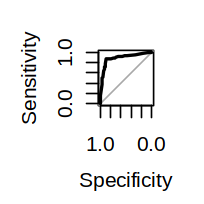

In [141]:
metric = "Accuracy"

control = trainControl(method="cv", number=5, classProbs = TRUE)

 tunegrid <- expand.grid(fL = 0:5,
                            usekernel = c(TRUE,FALSE),
                            adjust = seq(0, 5, by = 1)
                            )
knn_fit = train(y~., data = counts_train, metric = metric, method="knn",
                  preProcess = c("center","scale"), trControl = control,
               tuneLength=100)

knn_fit

tpred = predict(knn_fit, counts_train, type = "prob")
meta_data_train$classifier_score = as.numeric(tpred[,1])
youden_threshold = coords(plot.roc(meta_data_train$group, meta_data_train$classifier_score),
                         x="best", input="threshold", best.method="youden")$threshold

tpred = predict(knn_fit, newdata = counts_test, type="prob")
meta_data_test$classifier_score = as.numeric(tpred[,1])
roc(meta_data_test$group ~ meta_data_test$classifier_score, plot = FALSE, print.auc = TRUE)
meta_data_test$class_prediction <-
      ifelse(meta_data_test$classifier_score > youden_threshold,
             "Positive",
             "Negative"
      )
meta_data_train$class_prediction <-
      ifelse(meta_data_train$classifier_score > youden_threshold,
             "Positive",
             "Negative"
      )

confusionMatrix(factor(meta_data_test$class_prediction), factor(meta_data_test$group))
confusionMatrix(factor(meta_data_train$class_prediction), factor(meta_data_train$group))


In [142]:
print("train")
auc(meta_data_train$group ~ meta_data_train$classifier_score, plot = FALSE, print.auc = TRUE)
knn_auc_train = ci.auc(meta_data_train$group ~ meta_data_train$classifier_score, plot = FALSE, print.auc = TRUE)
knn_train =ci.coords(meta_data_train$group ~ meta_data_train$classifier_score, conf.level = 0.95, best.method="youden",
          x="best",
         ret = c("sensitivity","specificity", "accuracy","ppv","npv")) %>% data.frame()
youden=coords(roc(meta_data_train$group ~ meta_data_train$classifier_score),  best.method="youden",
          x="best")$threshold
print("test")
auc(meta_data_test$group ~ meta_data_test$classifier_score, plot = FALSE, print.auc = TRUE)
knn_auc_test = ci.auc(meta_data_test$group ~ meta_data_test$classifier_score, plot = FALSE, print.auc = TRUE)
knn_test = ci.coords(meta_data_test$group ~ meta_data_test$classifier_score,  input="threshold",
         x=youden,
         ret = c("sensitivity","specificity", "accuracy","ppv","npv")) %>% data.frame()

[1] "train"


Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



Area under the curve: 0.8958

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



[1] "test"


Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



Area under the curve: 0.9339

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



## NNET

# weights:  457
initial  value 36.858835 
final  value 0.551234 
converged
# weights:  457
initial  value 8.102625 
iter  10 value 0.538236
iter  20 value 0.538127
iter  20 value 0.538127
iter  20 value 0.538127
final  value 0.538127 
converged
# weights:  457
initial  value 1.406797 
iter  10 value 0.362075
iter  20 value 0.291752
iter  30 value 0.271300
iter  40 value 0.266573
iter  50 value 0.260782
iter  60 value 0.260443
iter  70 value 0.260434
final  value 0.260434 
converged
# weights:  457
initial  value 0.636518 
iter  10 value 0.367032
iter  20 value 0.273331
iter  30 value 0.225747
iter  40 value 0.112777
iter  50 value 0.093232
iter  60 value 0.083574
iter  70 value 0.075792
iter  80 value 0.072060
iter  90 value 0.067691
iter 100 value 0.062617
final  value 0.062617 
stopped after 100 iterations
# weights:  457
initial  value 0.576632 
iter  10 value 0.321987
iter  20 value 0.219984
iter  30 value 0.185541
iter  40 value 0.146951
iter  50 value 0.120718
iter  60 value 0.11

Warning message:
“model fit failed for Fold1: decay=5e-01, size= 10 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1521) weights
”
Warning message:
“model fit failed for Fold1: decay=1e-01, size= 10 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1521) weights
”
Warning message:
“model fit failed for Fold1: decay=1e-02, size= 10 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1521) weights
”
Warning message:
“model fit failed for Fold1: decay=1e-03, size= 10 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1521) weights
”
Warning message:
“model fit failed for Fold1: decay=1e-04, size= 10 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1521) weights
”
Warning message:
“model fit failed for Fold1: decay=1e-05, size= 10 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1521) weights
”
Warning message:
“model fit failed for Fold1: decay=1e-06, size= 10 Error in nnet.default(x, y

Warning message:
“model fit failed for Fold1: decay=1e-07, size= 45 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (6841) weights
”
Warning message:
“model fit failed for Fold1: decay=5e-01, size= 50 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (7601) weights
”
Warning message:
“model fit failed for Fold1: decay=1e-01, size= 50 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (7601) weights
”
Warning message:
“model fit failed for Fold1: decay=1e-02, size= 50 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (7601) weights
”
Warning message:
“model fit failed for Fold1: decay=1e-03, size= 50 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (7601) weights
”
Warning message:
“model fit failed for Fold1: decay=1e-04, size= 50 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (7601) weights
”
Warning message:
“model fit failed for Fold1: decay=1e-05, size= 50 Error in nnet.default(x, y

Warning message:
“model fit failed for Fold1: decay=1e-06, size= 80 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (12161) weights
”
Warning message:
“model fit failed for Fold1: decay=1e-07, size= 80 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (12161) weights
”
Warning message:
“model fit failed for Fold1: decay=5e-01, size= 85 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (12921) weights
”
Warning message:
“model fit failed for Fold1: decay=1e-01, size= 85 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (12921) weights
”
Warning message:
“model fit failed for Fold1: decay=1e-02, size= 85 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (12921) weights
”
Warning message:
“model fit failed for Fold1: decay=1e-03, size= 85 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (12921) weights
”
Warning message:
“model fit failed for Fold1: decay=1e-04, size= 85 Error in nnet.defaul

Warning message:
“model fit failed for Fold1: decay=1e-04, size=115 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (17481) weights
”
Warning message:
“model fit failed for Fold1: decay=1e-05, size=115 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (17481) weights
”
Warning message:
“model fit failed for Fold1: decay=1e-06, size=115 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (17481) weights
”
Warning message:
“model fit failed for Fold1: decay=1e-07, size=115 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (17481) weights
”
Warning message:
“model fit failed for Fold1: decay=5e-01, size=120 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (18241) weights
”
Warning message:
“model fit failed for Fold1: decay=1e-01, size=120 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (18241) weights
”
Warning message:
“model fit failed for Fold1: decay=1e-02, size=120 Error in nnet.defaul

# weights:  457
initial  value 37.236133 
final  value 0.556728 
converged
# weights:  457
initial  value 7.956799 
iter  10 value 0.540734
iter  20 value 0.532354
final  value 0.532351 
converged
# weights:  457
initial  value 1.393364 
iter  10 value 0.381684
iter  20 value 0.297684
iter  30 value 0.267751
iter  40 value 0.264537
iter  50 value 0.264007
iter  60 value 0.263098
iter  70 value 0.263036
iter  80 value 0.263034
final  value 0.263034 
converged
# weights:  457
initial  value 0.769826 
iter  10 value 0.281180
iter  20 value 0.194837
iter  30 value 0.151980
iter  40 value 0.114704
iter  50 value 0.081934
iter  60 value 0.074384
iter  70 value 0.068412
iter  80 value 0.063610
iter  90 value 0.061741
iter 100 value 0.060733
final  value 0.060733 
stopped after 100 iterations
# weights:  457
initial  value 0.587090 
iter  10 value 0.261718
iter  20 value 0.154749
iter  30 value 0.122982
iter  40 value 0.098188
iter  50 value 0.077823
iter  60 value 0.059845
iter  70 value 0.05

Warning message:
“model fit failed for Fold2: decay=5e-01, size= 10 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1521) weights
”
Warning message:
“model fit failed for Fold2: decay=1e-01, size= 10 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1521) weights
”
Warning message:
“model fit failed for Fold2: decay=1e-02, size= 10 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1521) weights
”
Warning message:
“model fit failed for Fold2: decay=1e-03, size= 10 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1521) weights
”
Warning message:
“model fit failed for Fold2: decay=1e-04, size= 10 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1521) weights
”
Warning message:
“model fit failed for Fold2: decay=1e-05, size= 10 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1521) weights
”
Warning message:
“model fit failed for Fold2: decay=1e-06, size= 10 Error in nnet.default(x, y

Warning message:
“model fit failed for Fold2: decay=1e-07, size= 45 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (6841) weights
”
Warning message:
“model fit failed for Fold2: decay=5e-01, size= 50 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (7601) weights
”
Warning message:
“model fit failed for Fold2: decay=1e-01, size= 50 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (7601) weights
”
Warning message:
“model fit failed for Fold2: decay=1e-02, size= 50 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (7601) weights
”
Warning message:
“model fit failed for Fold2: decay=1e-03, size= 50 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (7601) weights
”
Warning message:
“model fit failed for Fold2: decay=1e-04, size= 50 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (7601) weights
”
Warning message:
“model fit failed for Fold2: decay=1e-05, size= 50 Error in nnet.default(x, y

Warning message:
“model fit failed for Fold2: decay=1e-06, size= 80 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (12161) weights
”
Warning message:
“model fit failed for Fold2: decay=1e-07, size= 80 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (12161) weights
”
Warning message:
“model fit failed for Fold2: decay=5e-01, size= 85 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (12921) weights
”
Warning message:
“model fit failed for Fold2: decay=1e-01, size= 85 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (12921) weights
”
Warning message:
“model fit failed for Fold2: decay=1e-02, size= 85 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (12921) weights
”
Warning message:
“model fit failed for Fold2: decay=1e-03, size= 85 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (12921) weights
”
Warning message:
“model fit failed for Fold2: decay=1e-04, size= 85 Error in nnet.defaul

Warning message:
“model fit failed for Fold2: decay=1e-04, size=115 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (17481) weights
”
Warning message:
“model fit failed for Fold2: decay=1e-05, size=115 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (17481) weights
”
Warning message:
“model fit failed for Fold2: decay=1e-06, size=115 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (17481) weights
”
Warning message:
“model fit failed for Fold2: decay=1e-07, size=115 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (17481) weights
”
Warning message:
“model fit failed for Fold2: decay=5e-01, size=120 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (18241) weights
”
Warning message:
“model fit failed for Fold2: decay=1e-01, size=120 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (18241) weights
”
Warning message:
“model fit failed for Fold2: decay=1e-02, size=120 Error in nnet.defaul

# weights:  457
initial  value 37.327992 
final  value 0.562150 
converged
# weights:  457
initial  value 9.126071 
iter  10 value 0.541566
iter  20 value 0.541382
iter  20 value 0.541382
iter  20 value 0.541382
final  value 0.541382 
converged
# weights:  457
initial  value 1.288869 
iter  10 value 0.404872
iter  20 value 0.317832
iter  30 value 0.301342
iter  40 value 0.294656
iter  50 value 0.284034
iter  60 value 0.282753
iter  70 value 0.280421
iter  80 value 0.280254
iter  90 value 0.280234
iter 100 value 0.280231
final  value 0.280231 
stopped after 100 iterations
# weights:  457
initial  value 0.805864 
iter  10 value 0.385796
iter  20 value 0.215007
iter  30 value 0.142164
iter  40 value 0.118862
iter  50 value 0.102025
iter  60 value 0.093382
iter  70 value 0.090321
iter  80 value 0.086745
iter  90 value 0.080964
iter 100 value 0.079275
final  value 0.079275 
stopped after 100 iterations
# weights:  457
initial  value 0.603304 
iter  10 value 0.297520
iter  20 value 0.226650


Warning message:
“model fit failed for Fold3: decay=5e-01, size= 10 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1521) weights
”
Warning message:
“model fit failed for Fold3: decay=1e-01, size= 10 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1521) weights
”
Warning message:
“model fit failed for Fold3: decay=1e-02, size= 10 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1521) weights
”
Warning message:
“model fit failed for Fold3: decay=1e-03, size= 10 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1521) weights
”
Warning message:
“model fit failed for Fold3: decay=1e-04, size= 10 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1521) weights
”
Warning message:
“model fit failed for Fold3: decay=1e-05, size= 10 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1521) weights
”
Warning message:
“model fit failed for Fold3: decay=1e-06, size= 10 Error in nnet.default(x, y

Warning message:
“model fit failed for Fold3: decay=1e-07, size= 45 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (6841) weights
”
Warning message:
“model fit failed for Fold3: decay=5e-01, size= 50 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (7601) weights
”
Warning message:
“model fit failed for Fold3: decay=1e-01, size= 50 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (7601) weights
”
Warning message:
“model fit failed for Fold3: decay=1e-02, size= 50 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (7601) weights
”
Warning message:
“model fit failed for Fold3: decay=1e-03, size= 50 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (7601) weights
”
Warning message:
“model fit failed for Fold3: decay=1e-04, size= 50 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (7601) weights
”
Warning message:
“model fit failed for Fold3: decay=1e-05, size= 50 Error in nnet.default(x, y

Warning message:
“model fit failed for Fold3: decay=1e-06, size= 80 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (12161) weights
”
Warning message:
“model fit failed for Fold3: decay=1e-07, size= 80 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (12161) weights
”
Warning message:
“model fit failed for Fold3: decay=5e-01, size= 85 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (12921) weights
”
Warning message:
“model fit failed for Fold3: decay=1e-01, size= 85 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (12921) weights
”
Warning message:
“model fit failed for Fold3: decay=1e-02, size= 85 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (12921) weights
”
Warning message:
“model fit failed for Fold3: decay=1e-03, size= 85 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (12921) weights
”
Warning message:
“model fit failed for Fold3: decay=1e-04, size= 85 Error in nnet.defaul

Warning message:
“model fit failed for Fold3: decay=1e-04, size=115 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (17481) weights
”
Warning message:
“model fit failed for Fold3: decay=1e-05, size=115 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (17481) weights
”
Warning message:
“model fit failed for Fold3: decay=1e-06, size=115 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (17481) weights
”
Warning message:
“model fit failed for Fold3: decay=1e-07, size=115 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (17481) weights
”
Warning message:
“model fit failed for Fold3: decay=5e-01, size=120 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (18241) weights
”
Warning message:
“model fit failed for Fold3: decay=1e-01, size=120 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (18241) weights
”
Warning message:
“model fit failed for Fold3: decay=1e-02, size=120 Error in nnet.defaul

# weights:  457
initial  value 36.685366 
final  value 0.551234 
converged
# weights:  457
initial  value 8.307202 
iter  10 value 0.538315
iter  20 value 0.537843
final  value 0.537842 
converged
# weights:  457
initial  value 1.276467 
iter  10 value 0.353550
iter  20 value 0.296468
iter  30 value 0.280383
iter  40 value 0.277238
iter  50 value 0.275853
iter  60 value 0.275645
iter  70 value 0.275623
iter  80 value 0.275621
final  value 0.275621 
converged
# weights:  457
initial  value 0.696733 
iter  10 value 0.327555
iter  20 value 0.217512
iter  30 value 0.151755
iter  40 value 0.116407
iter  50 value 0.093978
iter  60 value 0.080426
iter  70 value 0.076117
iter  80 value 0.074670
iter  90 value 0.074074
iter 100 value 0.072468
final  value 0.072468 
stopped after 100 iterations
# weights:  457
initial  value 0.662992 
iter  10 value 0.309157
iter  20 value 0.226723
iter  30 value 0.204764
iter  40 value 0.187589
iter  50 value 0.178711
iter  60 value 0.173179
iter  70 value 0.15

Warning message:
“model fit failed for Fold4: decay=5e-01, size= 10 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1521) weights
”
Warning message:
“model fit failed for Fold4: decay=1e-01, size= 10 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1521) weights
”
Warning message:
“model fit failed for Fold4: decay=1e-02, size= 10 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1521) weights
”
Warning message:
“model fit failed for Fold4: decay=1e-03, size= 10 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1521) weights
”
Warning message:
“model fit failed for Fold4: decay=1e-04, size= 10 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1521) weights
”
Warning message:
“model fit failed for Fold4: decay=1e-05, size= 10 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1521) weights
”
Warning message:
“model fit failed for Fold4: decay=1e-06, size= 10 Error in nnet.default(x, y

Warning message:
“model fit failed for Fold4: decay=1e-07, size= 45 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (6841) weights
”
Warning message:
“model fit failed for Fold4: decay=5e-01, size= 50 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (7601) weights
”
Warning message:
“model fit failed for Fold4: decay=1e-01, size= 50 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (7601) weights
”
Warning message:
“model fit failed for Fold4: decay=1e-02, size= 50 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (7601) weights
”
Warning message:
“model fit failed for Fold4: decay=1e-03, size= 50 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (7601) weights
”
Warning message:
“model fit failed for Fold4: decay=1e-04, size= 50 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (7601) weights
”
Warning message:
“model fit failed for Fold4: decay=1e-05, size= 50 Error in nnet.default(x, y

Warning message:
“model fit failed for Fold4: decay=1e-06, size= 80 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (12161) weights
”
Warning message:
“model fit failed for Fold4: decay=1e-07, size= 80 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (12161) weights
”
Warning message:
“model fit failed for Fold4: decay=5e-01, size= 85 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (12921) weights
”
Warning message:
“model fit failed for Fold4: decay=1e-01, size= 85 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (12921) weights
”
Warning message:
“model fit failed for Fold4: decay=1e-02, size= 85 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (12921) weights
”
Warning message:
“model fit failed for Fold4: decay=1e-03, size= 85 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (12921) weights
”
Warning message:
“model fit failed for Fold4: decay=1e-04, size= 85 Error in nnet.defaul

Warning message:
“model fit failed for Fold4: decay=1e-04, size=115 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (17481) weights
”
Warning message:
“model fit failed for Fold4: decay=1e-05, size=115 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (17481) weights
”
Warning message:
“model fit failed for Fold4: decay=1e-06, size=115 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (17481) weights
”
Warning message:
“model fit failed for Fold4: decay=1e-07, size=115 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (17481) weights
”
Warning message:
“model fit failed for Fold4: decay=5e-01, size=120 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (18241) weights
”
Warning message:
“model fit failed for Fold4: decay=1e-01, size=120 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (18241) weights
”
Warning message:
“model fit failed for Fold4: decay=1e-02, size=120 Error in nnet.defaul

# weights:  457
initial  value 38.839913 
final  value 0.551234 
converged
# weights:  457
initial  value 7.795314 
iter  10 value 0.527587
iter  20 value 0.527538
iter  20 value 0.527538
iter  20 value 0.527538
final  value 0.527538 
converged
# weights:  457
initial  value 1.240389 
iter  10 value 0.442811
iter  20 value 0.314471
iter  30 value 0.286758
iter  40 value 0.283233
iter  50 value 0.276870
iter  60 value 0.276234
iter  70 value 0.276119
iter  80 value 0.276086
iter  90 value 0.276084
final  value 0.276084 
converged
# weights:  457
initial  value 0.624641 
iter  10 value 0.384183
iter  20 value 0.295624
iter  30 value 0.253750
iter  40 value 0.200010
iter  50 value 0.142110
iter  60 value 0.116205
iter  70 value 0.111845
iter  80 value 0.109380
iter  90 value 0.105404
iter 100 value 0.083029
final  value 0.083029 
stopped after 100 iterations
# weights:  457
initial  value 0.547267 
iter  10 value 0.293876
iter  20 value 0.257946
iter  30 value 0.234284
iter  40 value 0.22

Warning message:
“model fit failed for Fold5: decay=5e-01, size= 10 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1521) weights
”
Warning message:
“model fit failed for Fold5: decay=1e-01, size= 10 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1521) weights
”
Warning message:
“model fit failed for Fold5: decay=1e-02, size= 10 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1521) weights
”
Warning message:
“model fit failed for Fold5: decay=1e-03, size= 10 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1521) weights
”
Warning message:
“model fit failed for Fold5: decay=1e-04, size= 10 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1521) weights
”
Warning message:
“model fit failed for Fold5: decay=1e-05, size= 10 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (1521) weights
”
Warning message:
“model fit failed for Fold5: decay=1e-06, size= 10 Error in nnet.default(x, y

Warning message:
“model fit failed for Fold5: decay=1e-07, size= 45 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (6841) weights
”
Warning message:
“model fit failed for Fold5: decay=5e-01, size= 50 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (7601) weights
”
Warning message:
“model fit failed for Fold5: decay=1e-01, size= 50 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (7601) weights
”
Warning message:
“model fit failed for Fold5: decay=1e-02, size= 50 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (7601) weights
”
Warning message:
“model fit failed for Fold5: decay=1e-03, size= 50 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (7601) weights
”
Warning message:
“model fit failed for Fold5: decay=1e-04, size= 50 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (7601) weights
”
Warning message:
“model fit failed for Fold5: decay=1e-05, size= 50 Error in nnet.default(x, y

Warning message:
“model fit failed for Fold5: decay=1e-06, size= 80 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (12161) weights
”
Warning message:
“model fit failed for Fold5: decay=1e-07, size= 80 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (12161) weights
”
Warning message:
“model fit failed for Fold5: decay=5e-01, size= 85 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (12921) weights
”
Warning message:
“model fit failed for Fold5: decay=1e-01, size= 85 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (12921) weights
”
Warning message:
“model fit failed for Fold5: decay=1e-02, size= 85 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (12921) weights
”
Warning message:
“model fit failed for Fold5: decay=1e-03, size= 85 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (12921) weights
”
Warning message:
“model fit failed for Fold5: decay=1e-04, size= 85 Error in nnet.defaul

Warning message:
“model fit failed for Fold5: decay=1e-04, size=115 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (17481) weights
”
Warning message:
“model fit failed for Fold5: decay=1e-05, size=115 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (17481) weights
”
Warning message:
“model fit failed for Fold5: decay=1e-06, size=115 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (17481) weights
”
Warning message:
“model fit failed for Fold5: decay=1e-07, size=115 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (17481) weights
”
Warning message:
“model fit failed for Fold5: decay=5e-01, size=120 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (18241) weights
”
Warning message:
“model fit failed for Fold5: decay=1e-01, size=120 Error in nnet.default(x, y, w, entropy = TRUE, ...) : 
  too many (18241) weights
”
Warning message:
“model fit failed for Fold5: decay=1e-02, size=120 Error in nnet.defaul

# weights:  761
initial  value 13.058199 
iter  10 value 0.644721
iter  20 value 0.635340
final  value 0.635325 
converged


Neural Network 

127 samples
150 predictors
  2 classes: 'Positive', 'Negative' 

Pre-processing: centered (150), scaled (150) 
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 101, 102, 103, 101, 101 
Resampling results across tuning parameters:

  decay  size  Accuracy   Kappa    
  1e-07    3   0.7885385  0.5769231
  1e-07    5   0.7795897  0.5581472
  1e-07   10         NaN        NaN
  1e-07   20         NaN        NaN
  1e-07   25         NaN        NaN
  1e-07   30         NaN        NaN
  1e-07   35         NaN        NaN
  1e-07   40         NaN        NaN
  1e-07   45         NaN        NaN
  1e-07   50         NaN        NaN
  1e-07   55         NaN        NaN
  1e-07   60         NaN        NaN
  1e-07   65         NaN        NaN
  1e-07   70         NaN        NaN
  1e-07   75         NaN        NaN
  1e-07   80         NaN        NaN
  1e-07   85         NaN        NaN
  1e-07   90         NaN        NaN
  1e-07   95         NaN        NaN
  1e-07  100      

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases




Call:
roc.formula(formula = meta_data_test$group ~ meta_data_test$classifier_score,     plot = FALSE, print.auc = TRUE)

Data: meta_data_test$classifier_score in 37 controls (meta_data_test$group Positive) > 18 cases (meta_data_test$group Negative).
Area under the curve: 0.9444

Warning message in confusionMatrix.default(factor(meta_data_test$class_prediction), :
“Levels are not in the same order for reference and data. Refactoring data to match.”


Confusion Matrix and Statistics

          Reference
Prediction Positive Negative
  Positive       31        2
  Negative        6       16
                                         
               Accuracy : 0.8545         
                 95% CI : (0.7334, 0.935)
    No Information Rate : 0.6727         
    P-Value [Acc > NIR] : 0.001913       
                                         
                  Kappa : 0.6875         
                                         
 Mcnemar's Test P-Value : 0.288844       
                                         
            Sensitivity : 0.8378         
            Specificity : 0.8889         
         Pos Pred Value : 0.9394         
         Neg Pred Value : 0.7273         
             Prevalence : 0.6727         
         Detection Rate : 0.5636         
   Detection Prevalence : 0.6000         
      Balanced Accuracy : 0.8634         
                                         
       'Positive' Class : Positive       
                    

Warning message in confusionMatrix.default(factor(meta_data_train$class_prediction), :
“Levels are not in the same order for reference and data. Refactoring data to match.”


Confusion Matrix and Statistics

          Reference
Prediction Positive Negative
  Positive       58       11
  Negative        5       53
                                          
               Accuracy : 0.874           
                 95% CI : (0.8035, 0.9262)
    No Information Rate : 0.5039          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.7482          
                                          
 Mcnemar's Test P-Value : 0.2113          
                                          
            Sensitivity : 0.9206          
            Specificity : 0.8281          
         Pos Pred Value : 0.8406          
         Neg Pred Value : 0.9138          
             Prevalence : 0.4961          
         Detection Rate : 0.4567          
   Detection Prevalence : 0.5433          
      Balanced Accuracy : 0.8744          
                                          
       'Positive' Class : Positive        


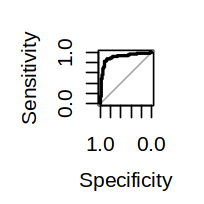

In [143]:
metric = "Accuracy"

control = trainControl(method="cv", number=5, classProbs = TRUE)
    model_weights <- ifelse(counts_train$y == names(table(counts_train$y)[1]),
                    (1/table(counts_train$y)[1]) * 0.5,
                    (1/table(counts_train$y)[2]) * 0.5)
  tunegrid <- expand.grid(decay = c(0.5, 0.1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7),
                            size = c(3, 5, 10, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
                                    90, 95, 100, 105, 110, 115, 120))

nnet_fit = train(y~., data = counts_train, metric = metric, method="nnet",
                  preProcess = c("center","scale"), 
                  trControl = control,
               tuneGrid=tunegrid, weights=model_weights)

nnet_fit

tpred = predict(nnet_fit, counts_train, type = "prob")
meta_data_train$classifier_score = as.numeric(tpred[,1])
youden_threshold = coords(plot.roc(meta_data_train$group, meta_data_train$classifier_score),
                         x="best", input="threshold", best.method="youden")$threshold

tpred = predict(nnet_fit, newdata = counts_test, type="prob")
meta_data_test$classifier_score = as.numeric(tpred[,1])
roc(meta_data_test$group ~ meta_data_test$classifier_score, plot = FALSE, print.auc = TRUE)
meta_data_test$class_prediction <-
      ifelse(meta_data_test$classifier_score > youden_threshold,
             "Positive",
             "Negative"
      )
meta_data_train$class_prediction <-
      ifelse(meta_data_train$classifier_score > youden_threshold,
             "Positive",
             "Negative"
      )

confusionMatrix(factor(meta_data_test$class_prediction), factor(meta_data_test$group))
confusionMatrix(factor(meta_data_train$class_prediction), factor(meta_data_train$group))


In [144]:
print("train")
auc(meta_data_train$group ~ meta_data_train$classifier_score, plot = FALSE, print.auc = TRUE)
nnet_auc_train = ci.auc(meta_data_train$group ~ meta_data_train$classifier_score, plot = FALSE, print.auc = TRUE)
nnet_train =ci.coords(meta_data_train$group ~ meta_data_train$classifier_score, conf.level = 0.95, best.method="youden",
          x="best",
         ret = c("sensitivity","specificity", "accuracy","ppv","npv")) %>% data.frame()
youden=coords(roc(meta_data_train$group ~ meta_data_train$classifier_score),  best.method="youden",
          x="best")$threshold
print("test")
auc(meta_data_test$group ~ meta_data_test$classifier_score, plot = FALSE, print.auc = TRUE)
nnet_auc_test = ci.auc(meta_data_test$group ~ meta_data_test$classifier_score, plot = FALSE, print.auc = TRUE)
nnet_test = ci.coords(meta_data_test$group ~ meta_data_test$classifier_score,  input="threshold",
         x=youden,
         ret = c("sensitivity","specificity", "accuracy","ppv","npv")) %>% data.frame()

[1] "train"


Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



Area under the curve: 0.9107

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



[1] "test"


Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



Area under the curve: 0.9444

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



## EXTRATREES

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases




Call:
roc.formula(formula = meta_data_test$group ~ meta_data_test$classifier_score,     plot = FALSE, print.auc = TRUE)

Data: meta_data_test$classifier_score in 37 controls (meta_data_test$group Positive) > 18 cases (meta_data_test$group Negative).
Area under the curve: 0.9429

Warning message in confusionMatrix.default(factor(meta_data_test$class_prediction), :
“Levels are not in the same order for reference and data. Refactoring data to match.”


Confusion Matrix and Statistics

          Reference
Prediction Positive Negative
  Positive       29        2
  Negative        8       16
                                         
               Accuracy : 0.8182         
                 95% CI : (0.691, 0.9092)
    No Information Rate : 0.6727         
    P-Value [Acc > NIR] : 0.01259        
                                         
                  Kappa : 0.6196         
                                         
 Mcnemar's Test P-Value : 0.11385        
                                         
            Sensitivity : 0.7838         
            Specificity : 0.8889         
         Pos Pred Value : 0.9355         
         Neg Pred Value : 0.6667         
             Prevalence : 0.6727         
         Detection Rate : 0.5273         
   Detection Prevalence : 0.5636         
      Balanced Accuracy : 0.8363         
                                         
       'Positive' Class : Positive       
                    

Warning message in confusionMatrix.default(factor(meta_data_train$class_prediction), :
“Levels are not in the same order for reference and data. Refactoring data to match.”


Confusion Matrix and Statistics

          Reference
Prediction Positive Negative
  Positive       62        3
  Negative        1       61
                                          
               Accuracy : 0.9685          
                 95% CI : (0.9213, 0.9914)
    No Information Rate : 0.5039          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.937           
                                          
 Mcnemar's Test P-Value : 0.6171          
                                          
            Sensitivity : 0.9841          
            Specificity : 0.9531          
         Pos Pred Value : 0.9538          
         Neg Pred Value : 0.9839          
             Prevalence : 0.4961          
         Detection Rate : 0.4882          
   Detection Prevalence : 0.5118          
      Balanced Accuracy : 0.9686          
                                          
       'Positive' Class : Positive        


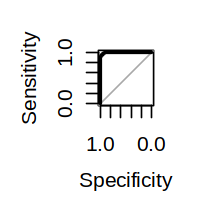

In [145]:
require(ranger)
    control <- trainControl(method="cv",number=5, 
                            classProbs = TRUE)
        
    tunegrid <- expand.grid(mtry = seq(5, ncol(counts_train), by = 5),
                           min.node.size = seq(2,10),
                            splitrule = "extratrees"
                           )

    metric <- "Accuracy"
    
    counts_train$y <- meta_data_train$group

    rf_fit <- train(y~., 
                          data=counts_train, 
                          method='ranger', 
                          metric='Accuracy', 
                          tuneGrid = tunegrid, 
                          trControl=control,
#                           preProc = c("center", "scale"),
                        na.action = na.pass
                          )
    



tpred = predict(rf_fit, counts_train, type = "prob")
meta_data_train$classifier_score = as.numeric(tpred[,1])
youden_threshold = coords(plot.roc(meta_data_train$group, meta_data_train$classifier_score),
                         x="best", input="threshold", best.method="youden")$threshold

tpred = predict(rf_fit, newdata = counts_test, type="prob")
meta_data_test$classifier_score = as.numeric(tpred[,1])
roc(meta_data_test$group ~ meta_data_test$classifier_score, plot = FALSE, print.auc = TRUE)
meta_data_test$class_prediction <-
      ifelse(meta_data_test$classifier_score > youden_threshold,
             "Positive",
             "Negative"
      )
meta_data_train$class_prediction <-
      ifelse(meta_data_train$classifier_score > youden_threshold,
             "Positive",
             "Negative"
      )

confusionMatrix(factor(meta_data_test$class_prediction), factor(meta_data_test$group))
confusionMatrix(factor(meta_data_train$class_prediction), factor(meta_data_train$group))


In [146]:
print("train")
auc(meta_data_train$group ~ meta_data_train$classifier_score, plot = FALSE, print.auc = TRUE)
extratrees_auc_train = ci.auc(meta_data_train$group ~ meta_data_train$classifier_score, plot = FALSE, print.auc = TRUE)
extratrees_train =ci.coords(meta_data_train$group ~ meta_data_train$classifier_score, conf.level = 0.95, best.method="youden",
          x="best",
         ret = c("sensitivity","specificity", "accuracy","ppv","npv")) %>% data.frame()
youden=coords(roc(meta_data_train$group ~ meta_data_train$classifier_score),  best.method="youden",
          x="best")$threshold
print("test")
auc(meta_data_test$group ~ meta_data_test$classifier_score, plot = FALSE, print.auc = TRUE)
extratress_auc_test = ci.auc(meta_data_test$group ~ meta_data_test$classifier_score, plot = FALSE, print.auc = TRUE)
extratrees_test = ci.coords(meta_data_test$group ~ meta_data_test$classifier_score,  input="threshold",
         x=youden,
         ret = c("sensitivity","specificity", "accuracy","ppv","npv")) %>% data.frame()

[1] "train"


Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



Area under the curve: 0.9968

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



[1] "test"


Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



Area under the curve: 0.9429

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



## PAM

123456789101112131415161718192021222324252627282930111111

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases




Call:
roc.formula(formula = meta_data_test$group ~ meta_data_test$classifier_score,     plot = FALSE, print.auc = TRUE)

Data: meta_data_test$classifier_score in 37 controls (meta_data_test$group Positive) > 18 cases (meta_data_test$group Negative).
Area under the curve: 0.9384

Warning message in confusionMatrix.default(factor(meta_data_test$class_prediction), :
“Levels are not in the same order for reference and data. Refactoring data to match.”


Confusion Matrix and Statistics

          Reference
Prediction Positive Negative
  Positive       29        2
  Negative        8       16
                                         
               Accuracy : 0.8182         
                 95% CI : (0.691, 0.9092)
    No Information Rate : 0.6727         
    P-Value [Acc > NIR] : 0.01259        
                                         
                  Kappa : 0.6196         
                                         
 Mcnemar's Test P-Value : 0.11385        
                                         
            Sensitivity : 0.7838         
            Specificity : 0.8889         
         Pos Pred Value : 0.9355         
         Neg Pred Value : 0.6667         
             Prevalence : 0.6727         
         Detection Rate : 0.5273         
   Detection Prevalence : 0.5636         
      Balanced Accuracy : 0.8363         
                                         
       'Positive' Class : Positive       
                    

Warning message in confusionMatrix.default(factor(meta_data_train$class_prediction), :
“Levels are not in the same order for reference and data. Refactoring data to match.”


Confusion Matrix and Statistics

          Reference
Prediction Positive Negative
  Positive       54        9
  Negative        9       55
                                          
               Accuracy : 0.8583          
                 95% CI : (0.7853, 0.9138)
    No Information Rate : 0.5039          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.7165          
                                          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.8571          
            Specificity : 0.8594          
         Pos Pred Value : 0.8571          
         Neg Pred Value : 0.8594          
             Prevalence : 0.4961          
         Detection Rate : 0.4252          
   Detection Prevalence : 0.4961          
      Balanced Accuracy : 0.8583          
                                          
       'Positive' Class : Positive        


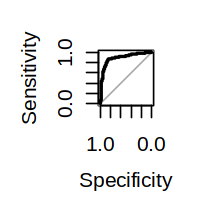

In [147]:
 control <- trainControl(method="cv",number=5)
    
    metric <- "Accuracy"
    counts_train$y <- factor(meta_data_train$group)

    pam_fit <- train(y~., 
                    data=counts_train, 
                    method='pam', 
                    metric = metric,
                    trControl=control,
                    tuneLength = 20,
                    preProcess = c("center","scale"))


tpred = predict(pam_fit, counts_train, type = "prob")
meta_data_train$classifier_score = as.numeric(tpred[,1])
youden_threshold = coords(plot.roc(meta_data_train$group, meta_data_train$classifier_score),
                         x="best", input="threshold", best.method="youden")$threshold

tpred = predict(pam_fit, newdata = counts_test, type="prob")
meta_data_test$classifier_score = as.numeric(tpred[,1])
roc(meta_data_test$group ~ meta_data_test$classifier_score, plot = FALSE, print.auc = TRUE)
meta_data_test$class_prediction <-
      ifelse(meta_data_test$classifier_score > youden_threshold,
             "Positive",
             "Negative"
      )
meta_data_train$class_prediction <-
      ifelse(meta_data_train$classifier_score > youden_threshold,
             "Positive",
             "Negative"
      )

confusionMatrix(factor(meta_data_test$class_prediction), factor(meta_data_test$group))
confusionMatrix(factor(meta_data_train$class_prediction), factor(meta_data_train$group))


In [148]:
print("train")
auc(meta_data_train$group ~ meta_data_train$classifier_score, plot = FALSE, print.auc = TRUE)
pam_auc_train = ci.auc(meta_data_train$group ~ meta_data_train$classifier_score, plot = FALSE, print.auc = TRUE)
pam_train =ci.coords(meta_data_train$group ~ meta_data_train$classifier_score, conf.level = 0.95, best.method="youden",
          x="best",
         ret = c("sensitivity","specificity", "accuracy","ppv","npv")) %>% data.frame()
youden=coords(roc(meta_data_train$group ~ meta_data_train$classifier_score),  best.method="youden",
          x="best")$threshold
print("test")
auc(meta_data_test$group ~ meta_data_test$classifier_score, plot = FALSE, print.auc = TRUE)
pam_auc_test = ci.auc(meta_data_test$group ~ meta_data_test$classifier_score, plot = FALSE, print.auc = TRUE)
pam_test = ci.coords(meta_data_test$group ~ meta_data_test$classifier_score,  input="threshold",
         x=youden,
         ret = c("sensitivity","specificity", "accuracy","ppv","npv")) %>% data.frame()

[1] "train"


Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



Area under the curve: 0.8958

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



[1] "test"


Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



Area under the curve: 0.9384

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



## RPART

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases




Call:
roc.formula(formula = meta_data_test$group ~ meta_data_test$classifier_score,     plot = FALSE, print.auc = TRUE)

Data: meta_data_test$classifier_score in 37 controls (meta_data_test$group Positive) > 18 cases (meta_data_test$group Negative).
Area under the curve: 0.7935

Warning message in confusionMatrix.default(factor(meta_data_test$class_prediction), :
“Levels are not in the same order for reference and data. Refactoring data to match.”


Confusion Matrix and Statistics

          Reference
Prediction Positive Negative
  Positive       32        5
  Negative        5       13
                                         
               Accuracy : 0.8182         
                 95% CI : (0.691, 0.9092)
    No Information Rate : 0.6727         
    P-Value [Acc > NIR] : 0.01259        
                                         
                  Kappa : 0.5871         
                                         
 Mcnemar's Test P-Value : 1.00000        
                                         
            Sensitivity : 0.8649         
            Specificity : 0.7222         
         Pos Pred Value : 0.8649         
         Neg Pred Value : 0.7222         
             Prevalence : 0.6727         
         Detection Rate : 0.5818         
   Detection Prevalence : 0.6727         
      Balanced Accuracy : 0.7935         
                                         
       'Positive' Class : Positive       
                    

Warning message in confusionMatrix.default(factor(meta_data_train$class_prediction), :
“Levels are not in the same order for reference and data. Refactoring data to match.”


Confusion Matrix and Statistics

          Reference
Prediction Positive Negative
  Positive       56       15
  Negative        7       49
                                          
               Accuracy : 0.8268          
                 95% CI : (0.7496, 0.8881)
    No Information Rate : 0.5039          
    P-Value [Acc > NIR] : 3.522e-14       
                                          
                  Kappa : 0.6539          
                                          
 Mcnemar's Test P-Value : 0.1356          
                                          
            Sensitivity : 0.8889          
            Specificity : 0.7656          
         Pos Pred Value : 0.7887          
         Neg Pred Value : 0.8750          
             Prevalence : 0.4961          
         Detection Rate : 0.4409          
   Detection Prevalence : 0.5591          
      Balanced Accuracy : 0.8273          
                                          
       'Positive' Class : Positive        


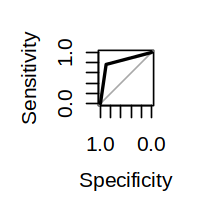

In [149]:
metric <- "Accuracy"

    control <- trainControl(method="cv",number=5)

    
    counts_train$y <- factor(meta_data_train$group)
    
    model_weights <- ifelse(counts_train$y == names(table(counts_train$y)[1]),
                    (1/table(counts_train$y)[1]) * 0.5,
                    (1/table(counts_train$y)[2]) * 0.5)

    rpart_fit <- train(y~., 
                    data=counts_train, 
                    metric = metric,
                    method='rpart', 
#                     preProcess = c("center","scale"),
                    trControl=control,
                    weights = model_weights,
                    tuneLength = 20)


tpred = predict(rpart_fit, counts_train, type = "prob")
meta_data_train$classifier_score = as.numeric(tpred[,1])
youden_threshold = coords(plot.roc(meta_data_train$group, meta_data_train$classifier_score),
                         x="best", input="threshold", best.method="youden")$threshold

tpred = predict(rpart_fit, newdata = counts_test, type="prob")
meta_data_test$classifier_score = as.numeric(tpred[,1])
roc(meta_data_test$group ~ meta_data_test$classifier_score, plot = FALSE, print.auc = TRUE)
meta_data_test$class_prediction <-
      ifelse(meta_data_test$classifier_score > youden_threshold,
             "Positive",
             "Negative"
      )
meta_data_train$class_prediction <-
      ifelse(meta_data_train$classifier_score > youden_threshold,
             "Positive",
             "Negative"
      )

confusionMatrix(factor(meta_data_test$class_prediction), factor(meta_data_test$group))
confusionMatrix(factor(meta_data_train$class_prediction), factor(meta_data_train$group))


In [150]:
print("train")
auc(meta_data_train$group ~ meta_data_train$classifier_score, plot = FALSE, print.auc = TRUE)
rpart_auc_train = ci.auc(meta_data_train$group ~ meta_data_train$classifier_score, plot = FALSE, print.auc = TRUE)
rpart_train =ci.coords(meta_data_train$group ~ meta_data_train$classifier_score, conf.level = 0.95, best.method="youden",
          x="best",
         ret = c("sensitivity","specificity", "accuracy","ppv","npv")) %>% data.frame()
youden=coords(roc(meta_data_train$group ~ meta_data_train$classifier_score),  best.method="youden",
          x="best")$threshold
print("test")
auc(meta_data_test$group ~ meta_data_test$classifier_score, plot = FALSE, print.auc = TRUE)
rpart_auc_test = ci.auc(meta_data_test$group ~ meta_data_test$classifier_score, plot = FALSE, print.auc = TRUE)
rpart_test = ci.coords(meta_data_test$group ~ meta_data_test$classifier_score,  input="threshold",
         x=youden,
         ret = c("sensitivity","specificity", "accuracy","ppv","npv")) %>% data.frame()

[1] "train"


Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



Area under the curve: 0.8273

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



[1] "test"


Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



Area under the curve: 0.7935

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



## C5

Warning message:
“'trials' should be <= 5 for this object. Predictions generated using 5 trials”
Warning message:
“'trials' should be <= 5 for this object. Predictions generated using 5 trials”
Warning message:
“'trials' should be <= 5 for this object. Predictions generated using 5 trials”
Warning message:
“'trials' should be <= 5 for this object. Predictions generated using 5 trials”
Warning message:
“'trials' should be <= 6 for this object. Predictions generated using 6 trials”
Warning message:
“'trials' should be <= 6 for this object. Predictions generated using 6 trials”
Warning message:
“'trials' should be <= 10 for this object. Predictions generated using 10 trials”
Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases




Call:
roc.formula(formula = meta_data_test$group ~ meta_data_test$classifier_score,     plot = FALSE, print.auc = TRUE)

Data: meta_data_test$classifier_score in 37 controls (meta_data_test$group Positive) > 18 cases (meta_data_test$group Negative).
Area under the curve: 0.9459

Warning message in confusionMatrix.default(factor(meta_data_test$class_prediction), :
“Levels are not in the same order for reference and data. Refactoring data to match.”


Confusion Matrix and Statistics

          Reference
Prediction Positive Negative
  Positive       31        3
  Negative        6       15
                                         
               Accuracy : 0.8364         
                 95% CI : (0.712, 0.9223)
    No Information Rate : 0.6727         
    P-Value [Acc > NIR] : 0.00521        
                                         
                  Kappa : 0.6436         
                                         
 Mcnemar's Test P-Value : 0.50499        
                                         
            Sensitivity : 0.8378         
            Specificity : 0.8333         
         Pos Pred Value : 0.9118         
         Neg Pred Value : 0.7143         
             Prevalence : 0.6727         
         Detection Rate : 0.5636         
   Detection Prevalence : 0.6182         
      Balanced Accuracy : 0.8356         
                                         
       'Positive' Class : Positive       
                    

Warning message in confusionMatrix.default(factor(meta_data_train$class_prediction), :
“Levels are not in the same order for reference and data. Refactoring data to match.”


Confusion Matrix and Statistics

          Reference
Prediction Positive Negative
  Positive       63        0
  Negative        0       64
                                     
               Accuracy : 1          
                 95% CI : (0.9714, 1)
    No Information Rate : 0.5039     
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0000     
            Specificity : 1.0000     
         Pos Pred Value : 1.0000     
         Neg Pred Value : 1.0000     
             Prevalence : 0.4961     
         Detection Rate : 0.4961     
   Detection Prevalence : 0.4961     
      Balanced Accuracy : 1.0000     
                                     
       'Positive' Class : Positive   
                                     

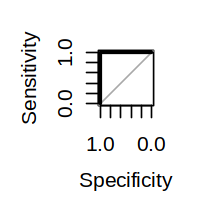

In [155]:
    control <- trainControl(method="cv",number=5)

    tunegrid <- expand.grid(winnow = c(TRUE,FALSE),
                            trials=c(1,5,10,15,20),
                            model="tree" )


    metric <- "Accuracy"
    counts_train$y <- factor(meta_data_train$group)

    model_weights <- ifelse(counts_train$y == names(table(counts_train$y)[1]),
                    (1/table(counts_train$y)[1]) * 0.5,
                    (1/table(counts_train$y)[2]) * 0.5)

    C5_fit <- train(y~.,
                    data = counts_train,
                    method = 'C5.0',
                    metric = metric,
                    trControl = control,
                    tuneGrid = tunegrid,
                    weigths = model_weights,
                    preProcess = c("center","scale"))


tpred = predict(C5_fit, counts_train, type = "prob")
meta_data_train$classifier_score = as.numeric(tpred[,1])
youden_threshold = coords(plot.roc(meta_data_train$group, meta_data_train$classifier_score),
                         x="best", input="threshold", best.method="youden")$threshold

tpred = predict(C5_fit, newdata = counts_test, type="prob")
meta_data_test$classifier_score = as.numeric(tpred[,1])
roc(meta_data_test$group ~ meta_data_test$classifier_score, plot = FALSE, print.auc = TRUE)
meta_data_test$class_prediction <-
      ifelse(meta_data_test$classifier_score > youden_threshold,
             "Positive",
             "Negative"
      )
meta_data_train$class_prediction <-
      ifelse(meta_data_train$classifier_score > youden_threshold,
             "Positive",
             "Negative"
      )

confusionMatrix(factor(meta_data_test$class_prediction), factor(meta_data_test$group))
confusionMatrix(factor(meta_data_train$class_prediction), factor(meta_data_train$group))


In [156]:
print("train")
auc(meta_data_train$group ~ meta_data_train$classifier_score, plot = FALSE, print.auc = TRUE)
c5_auc_train = ci.auc(meta_data_train$group ~ meta_data_train$classifier_score, plot = FALSE, print.auc = TRUE)
c5_train =ci.coords(meta_data_train$group ~ meta_data_train$classifier_score, conf.level = 0.95, best.method="youden",
          x="best",
         ret = c("sensitivity","specificity", "accuracy","ppv","npv")) %>% data.frame()
youden=coords(roc(meta_data_train$group ~ meta_data_train$classifier_score),  best.method="youden",
          x="best")$threshold
print("test")
auc(meta_data_test$group ~ meta_data_test$classifier_score, plot = FALSE, print.auc = TRUE)
c5_auc_test =ci.auc(meta_data_test$group ~ meta_data_test$classifier_score, plot = FALSE, print.auc = TRUE)
c5_test = ci.coords(meta_data_test$group ~ meta_data_test$classifier_score,  input="threshold",
         x=youden,
         ret = c("sensitivity","specificity", "accuracy","ppv","npv")) %>% data.frame()

[1] "train"


Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



Area under the curve: 1

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Warning message in ci.auc.roc(roc.default(response, predictor, ci = FALSE, ...), :
“ci.auc() of a ROC curve with AUC == 1 is always 1-1 and can be misleading.”
Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Warning message in ci.coords.roc(roc(response, predictor, ci = FALSE, ...), ...):
“ci.coords() of a ROC curve with AUC == 1 is always a null interval and can be misleading.”
Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



[1] "test"


Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



Area under the curve: 0.9459

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases

Setting levels: control = Positive, case = Negative

Setting direction: controls > cases



In [157]:
sensitivity = rbind( 
    c("C5", c5_train$sensitivity.50., c5_test$sensitivity.50.),
    c("GLM", glm_train$sensitivity.50., glm_test$sensitivity.50.),
    c("GLMNETLASSO",glmnet_lasso_train$sensitivity.50.,glmnet_lasso_test$specificity.50.),
c("GLMNETRIDGE",glmnet_ridge_train$sensitivity.50., glmnet_ridge_test$sensitivity.50.),
c("NNET",nnet_train$sensitivity.50., nnet_test$sensitivity.50.),
    c("RF",rf_train$sensitivity.50., rf_test$sensitivity.50.),
    c("SVMLIN",svm_lin_train$sensitivity.50., svm_lin_test$sensitivity.50.),
    c("LDA",lda_train$sensitivity.50., lda_test$sensitivity.50.),
    c("SVMRAD",svm_rad_train$sensitivity.50., svm_rad_test$sensitivity.50.),
    c("KNN", knn_train$sensitivity.50., knn_test$sensitivity.50.),
    c("NB",nb_train$sensitivity.50.,nb_test$sensitivity.50.),
        c("EXTRATREES", extratrees_train$sensitivity.50., extratrees_test$sensitivity.50.),
    c("PAM",pam_train$sensitivity.50., pam_test$sensitivity.50.),
    c("RPART",rpart_train$sensitivity.50., rpart_test$sensitivity.50.),
    c("GFS","0.946","0.962")
    )



In [305]:
specificity = rbind( 
    c("C5", c5_train$specificity.50., c5_test$specificity.50.),
    c("GLM", glm_train$specificity.50., glm_test$specificity.50.),
    c("GLMNETLASSO",glmnet_lasso_train$specificity.50.,glmnet_lasso_test$specificity.50.),
c("GLMNETRIDGE",glmnet_ridge_train$specificity.50., glmnet_ridge_test$specificity.50.),
c("NNET",nnet_train$specificity.50., nnet_test$specificity.50.),
    c("RF",rf_train$specificity.50., rf_test$specificity.50.),
    c("SVMLIN",svm_lin_train$specificity.50., svm_lin_test$specificity.50.),
    c("LDA",lda_train$specificity.50., lda_test$specificity.50.),
    c("SVMRAD",svm_rad_train$specificity.50., svm_rad_test$specificity.50.),
    c("KNN", knn_train$specificity.50., knn_test$specificity.50.),
    c("NB",nb_train$specificity.50.,nb_test$specificity.50.),
    c("EXTRATREES", extratrees_train$specificity.50., extratrees_test$specificity.50.),
    c("PAM",pam_train$specificity.50., pam_test$specificity.50.),
    c("RPART",rpart_train$specificity.50., rpart_test$specificity.50.),
    c("GFS","0.717","0.719")
    )



In [306]:
pdf("sens_spec.pdf", height=2, width=1.96)
options(repr.plot.height=1.88, repr.plot.width=1.96)
cbind(sensitivity, specificity) %>% data.frame()  %>% select(X1, X3, X6) %>% 
magrittr::set_colnames(.,c("Model","Sensitivity","Specificity")) %>%
reshape2::melt(., id.var="Model") %>% 
ggplot(aes(x=as.numeric(value), y=Model, shape=variable))+ geom_point() +
scale_shape_manual(values=c(1,2))+
theme_bw(base_size=8)+    
theme(axis.title=element_blank(), 
          axis.text.x=element_text(size=6, color="black"),
         legend.position="top", 
          axis.text.y=element_text(color="black"),
     legend.title=element_blank(),
     legend.text=element_text(size=6, color="black"),
     legend.key.size = unit(0.2, 'cm'),
     legend.key.height = unit(0.2, 'cm'))  +
 scale_y_discrete(limits=rev) +
geom_vline(xintercept = 0.95, color="#00D2DE", linetype = "dashed") +
geom_vline(xintercept = 0.8, color="#C5D86D", linetype="dashed")  +
xlim(0.4,1)
dev.off()

Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


png 
  2

In [ ]:
auc = rbind( 
    c("C5", c5_auc_train[2], c5_auc_test[2]),
    c("GLM", glm_train_auc[2], glm_test_auc[2]),
    c("GLMNETLASSO",glmnet_lasso_auc_train[2],glmnet_lasso_auc_test[2]),
c("GLMNETRIDGE",glmnet_ridge_auc_train[2], glmnet_ridge_auc_test[2]),
c("NNET",nnet_auc_train[2], nnet_auc_test[2]),
    c("RF",rf_auc_train[2], rf_test_auc[2]),
    c("SVMLIN",svm_lin_auc_train[2], svm_lin_auc_test[2]),
    c("LDA",lda_auc_train[2], lda_auc_test[2]),
    c("SVMRAD",svm_rad_auc_train[2], svm_rad_auc_test[2]),
    c("KNN", knn_auc_train[2], knn_auc_test[2]),
    c("NB",nb_auc_train[2],nb_auc_test[2]),
    c("EXTRATREES", extratrees_auc_train[2], extratress_auc_test[2]),
    c("PAM",pam_auc_train[2], pam_auc_test[2]),
    c("RPART",rpart_auc_train[2], rpart_auc_test[2]),
    c("GFS","0.946","0.962")
    )



In [198]:
library(scales)


Attaching package: ‘scales’


The following object is masked from ‘package:arsenal’:

    ordinal




In [230]:
pdf("ml_auc.pdf",height=1, width=2.5)
options(repr.plot.width=2.5, repr.plot.height=1)
auc %>% data.frame() %>% magrittr::set_colnames(., c("Model","Train","Test")) %>%
reshape2::melt(id.var=c("Model")) %>%
mutate(value = as.numeric(value)) %>%
ggplot(aes(x=Model, y=variable, fill=value)) + geom_tile() + 
scale_fill_gradient2(low="#FFBD46", mid="white", high="#3F218B", midpoint=0.8)+ theme_bw(base_size=6)+
theme(legend.position="none",
     legend.key.size=unit(0.2,"cm"),
     axis.title=element_blank(),
      axis.text=element_text(color="black", size=6),
      axis.text.x=element_text(angle=270, vjust=1, hjust=1),
      legend.title = element_text(angle = -90, size=6, color="black"),
     ) + scale_y_discrete(limits=rev) +
 guides(fill = guide_legend(title.position = "right"))+
scale_x_discrete(position="top")
dev.off()

png 
  2

In [260]:
tmp_auc = rbind( 
    c("C5", c5_auc_train, c5_auc_test),
    c("GLM", glm_train_auc, glm_test_auc),
    c("GLMNETLASSO",glmnet_lasso_auc_train,glmnet_lasso_auc_test),
c("GLMNETRIDGE",glmnet_ridge_auc_train, glmnet_ridge_auc_test),
c("NNET",nnet_auc_train, nnet_auc_test),
    c("RF",rf_auc_train, rf_test_auc),
    c("SVMLIN",svm_lin_auc_train, svm_lin_auc_test),
    c("LDA",lda_auc_train, lda_auc_test),
    c("SVMRAD",svm_rad_auc_train, svm_rad_auc_test),
    c("KNN", knn_auc_train, knn_auc_test),
    c("NB",nb_auc_train,nb_auc_test),
    c("EXTRATREES", extratrees_auc_train, extratress_auc_test),
    c("PAM",pam_auc_train, pam_auc_test),
    c("RPART",rpart_auc_train, rpart_auc_test)
    ) %>%data.frame() %>% 
 mutate_at(vars(X2, X3, X4,X5,X6,X7), as.numeric)

In [265]:
tmp_auc$col1 = paste0(format(round(tmp_auc$X3, 2), nsmall = 2)," [",format(round(tmp_auc$X2, 2), nsmall = 2),"-", format(round(tmp_auc$X4, 2), nsmall = 2),"]")
tmp_auc$col2 = paste0(format(round(tmp_auc$X6, 2), nsmall = 2)," [",format(round(tmp_auc$X5, 2), nsmall = 2),"-", format(round(tmp_auc$X7, 2), nsmall = 2),"]")

In [272]:
tmp_auc[,c(1,8,9)] %>% 
mutate(X1 = factor(X1,levels=c("C5","EXTRATREES","GLM",
"GLMNETLASSO", "GLMNETRIDGE", "NNET","RF","SVMLIN",
                            "LDA","SVMRAD","PAM","KNN","RPART","NB"
))) %>% arrange(X1) %>% select(col1, col2)

col1,col2
<chr>,<chr>
1.00 [1.00-1.00],0.95 [0.89-1.00]
1.00 [0.99-1.00],0.94 [0.89-1.00]
1.00 [1.00-1.00],0.57 [0.43-0.72]
1.00 [0.99-1.00],0.91 [0.83-0.98]
1.00 [0.99-1.00],0.91 [0.83-0.98]
0.91 [0.86-0.97],0.94 [0.88-1.00]
1.00 [1.00-1.00],0.95 [0.89-1.00]
1.00 [0.99-1.00],0.88 [0.80-0.97]
1.00 [1.00-1.00],0.71 [0.56-0.86]


In [303]:
tmp2 = rbind( 
    c("C5", c5_train, c5_test),
    c("GLM", glm_train, glm_test),
    c("GLMNETLASSO",glmnet_lasso_train,glmnet_lasso_test),
c("GLMNETRIDGE",glmnet_ridge_train, glmnet_ridge_test),
c("NNET",nnet_train, nnet_test),
    c("RF",rf_train, rf_test),
    c("SVMLIN",svm_lin_train, svm_lin_test),
    c("LDA",lda_train, lda_test),
    c("SVMRAD",svm_rad_train, svm_rad_test),
    c("KNN", knn_train, knn_test),
    c("NB",nb_train,nb_test),
    c("EXTRATREES", extratrees_train, extratrees_test),
    c("PAM",pam_train, pam_test),
    c("RPART",rpart_train, rpart_test)
    ) %>% data.frame() 

tmp2 = tmp2 %>% mutate_at(vars(colnames(tmp2)[-1]), as.numeric)
tmp2 = tmp2 %>% mutate(across(2:31, round, 2))
colnames(tmp2)[1]="X1"

tmp2$acc_train = paste0(tmp2$accuracy.50.," [", tmp2$accuracy.2.5., "-", tmp2$accuracy.97.5.,"]")
tmp2$acc_test = paste0(tmp2$`accuracy.50..1`," [", tmp2$`accuracy.2.5..1`, "-", tmp2$`accuracy.97.5..1`,"]")
tmp2$sens_train = paste0(tmp2$sensitivity.50.," [", tmp2$sensitivity.2.5., "-", tmp2$sensitivity.97.5.,"]")
tmp2$sens_test = paste0(tmp2$`sensitivity.50..1`," [", tmp2$`sensitivity.2.5..1`, "-", tmp2$`sensitivity.97.5..1`,"]")
tmp2$spec_train = paste0(tmp2$specificity.50.," [", tmp2$specificity.2.5., "-", tmp2$specificity.97.5.,"]")
tmp2$spec_test = paste0(tmp2$`specificity.50..1`," [", tmp2$`specificity.2.5..1`, "-", tmp2$`specificity.97.5..1`,"]")

In [304]:
tmp2 %>% 
mutate(X1 = factor(X1,levels=c("C5","EXTRATREES","GLM",
"GLMNETLASSO", "GLMNETRIDGE", "NNET","RF","SVMLIN",
                            "LDA","SVMRAD","PAM","KNN","RPART","NB"
))) %>% arrange(X1) %>% select(acc_train, acc_test, sens_train, sens_test, spec_train, spec_test
                )

acc_train,acc_test,sens_train,sens_test,spec_train,spec_test
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1 [1-1],0.84 [0.73-0.93],1 [1-1],0.83 [0.67-1],1 [1-1],0.84 [0.7-0.95]
0.98 [0.95-1],0.82 [0.71-0.91],0.98 [0.92-1],0.89 [0.72-1],0.98 [0.94-1],0.78 [0.65-0.89]
1 [1-1],0.6 [0.47-0.73],1 [1-1],0.39 [0.17-0.61],1 [1-1],0.7 [0.54-0.84]
0.98 [0.95-1],0.82 [0.71-0.91],0.98 [0.92-1],0.83 [0.67-1],0.98 [0.94-1],0.81 [0.68-0.92]
0.98 [0.95-1],0.82 [0.71-0.91],0.98 [0.92-1],0.83 [0.67-1],0.98 [0.94-1],0.81 [0.68-0.92]
0.88 [0.83-0.94],0.85 [0.76-0.93],0.86 [0.75-0.95],0.89 [0.72-1],0.9 [0.81-0.97],0.84 [0.73-0.95]
1 [1-1],0.8 [0.69-0.91],1 [1-1],0.83 [0.67-1],1 [1-1],0.78 [0.65-0.92]
0.98 [0.96-1],0.8 [0.69-0.89],0.97 [0.92-1],0.67 [0.44-0.89],1 [0.95-1],0.86 [0.76-0.97]
1 [1-1],0.58 [0.45-0.71],1 [1-1],0.67 [0.44-0.89],1 [1-1],0.54 [0.38-0.7]
